# BUAD 307: Marketing Fundamentals (Fall 2019)

As part of our first class, let's explore a dataset for that shows the amount of money (\\$) that a company has spent on offline mail and online channels, and their sales revenue (\\$) each day.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.api import tsa
from scipy.stats import t

# plotting defaults
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (18, 12)
get_colors = lambda length: plt.get_cmap('Spectral')(np.linspace(0, 1.0, length))

In [2]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (18, 12)

In [3]:
ads_sales_data_online = pd.read_excel('./data/ads_sales_data_online.xls', index_col=[0])
ads_sales_data_mailing = pd.read_excel('./data/ads_sales_data_mailing.xls', index_col=[0])

## Exploratory Data Analysis
Let's look at our data to see if there's anything unusual.

In [4]:
ads_sales_data_mailing.index = pd.to_datetime(ads_sales_data_mailing.index)
ads_sales_data_online.index = pd.to_datetime(ads_sales_data_online.index)

In [5]:
ads_sales_data_mailing.columns

Index(['ad_mail', 'discount', 'sales'], dtype='object')

In [6]:
ads_sales_data_mailing.head(10)

ad_mail  discount    sales
date                                  
2017-05-04      225         0   464.92
2017-05-05      200         0   449.48
2017-05-06       25         0   715.92
2017-05-07       25         0   634.45
2017-05-08      175         0   221.47
2017-05-09      600         0   218.45
2017-05-10      300         0   427.94
2017-05-11      300         0   852.94
2017-05-12      105         1  1445.92
2017-05-13       35         0   740.47

In [7]:
ads_sales_data_online.columns

Index(['ad_online', 'discount', 'sales'], dtype='object')

In [8]:
ads_sales_data_online.head(10)

ad_online  discount    sales
date                                    
2018-05-04     176.86         0   745.14
2018-05-05     221.07         0  1028.43
2018-05-06     353.72         0  1367.40
2018-05-07     486.36         0  1133.97
2018-05-08     309.50         0  1048.09
2018-05-09       0.00         1  1042.43
2018-05-10       0.00         1   961.95
2018-05-11     221.07         0   817.40
2018-05-12     265.29         0  1135.25
2018-05-13     265.29         0  1180.71

/anaconda3/envs/geopandas/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


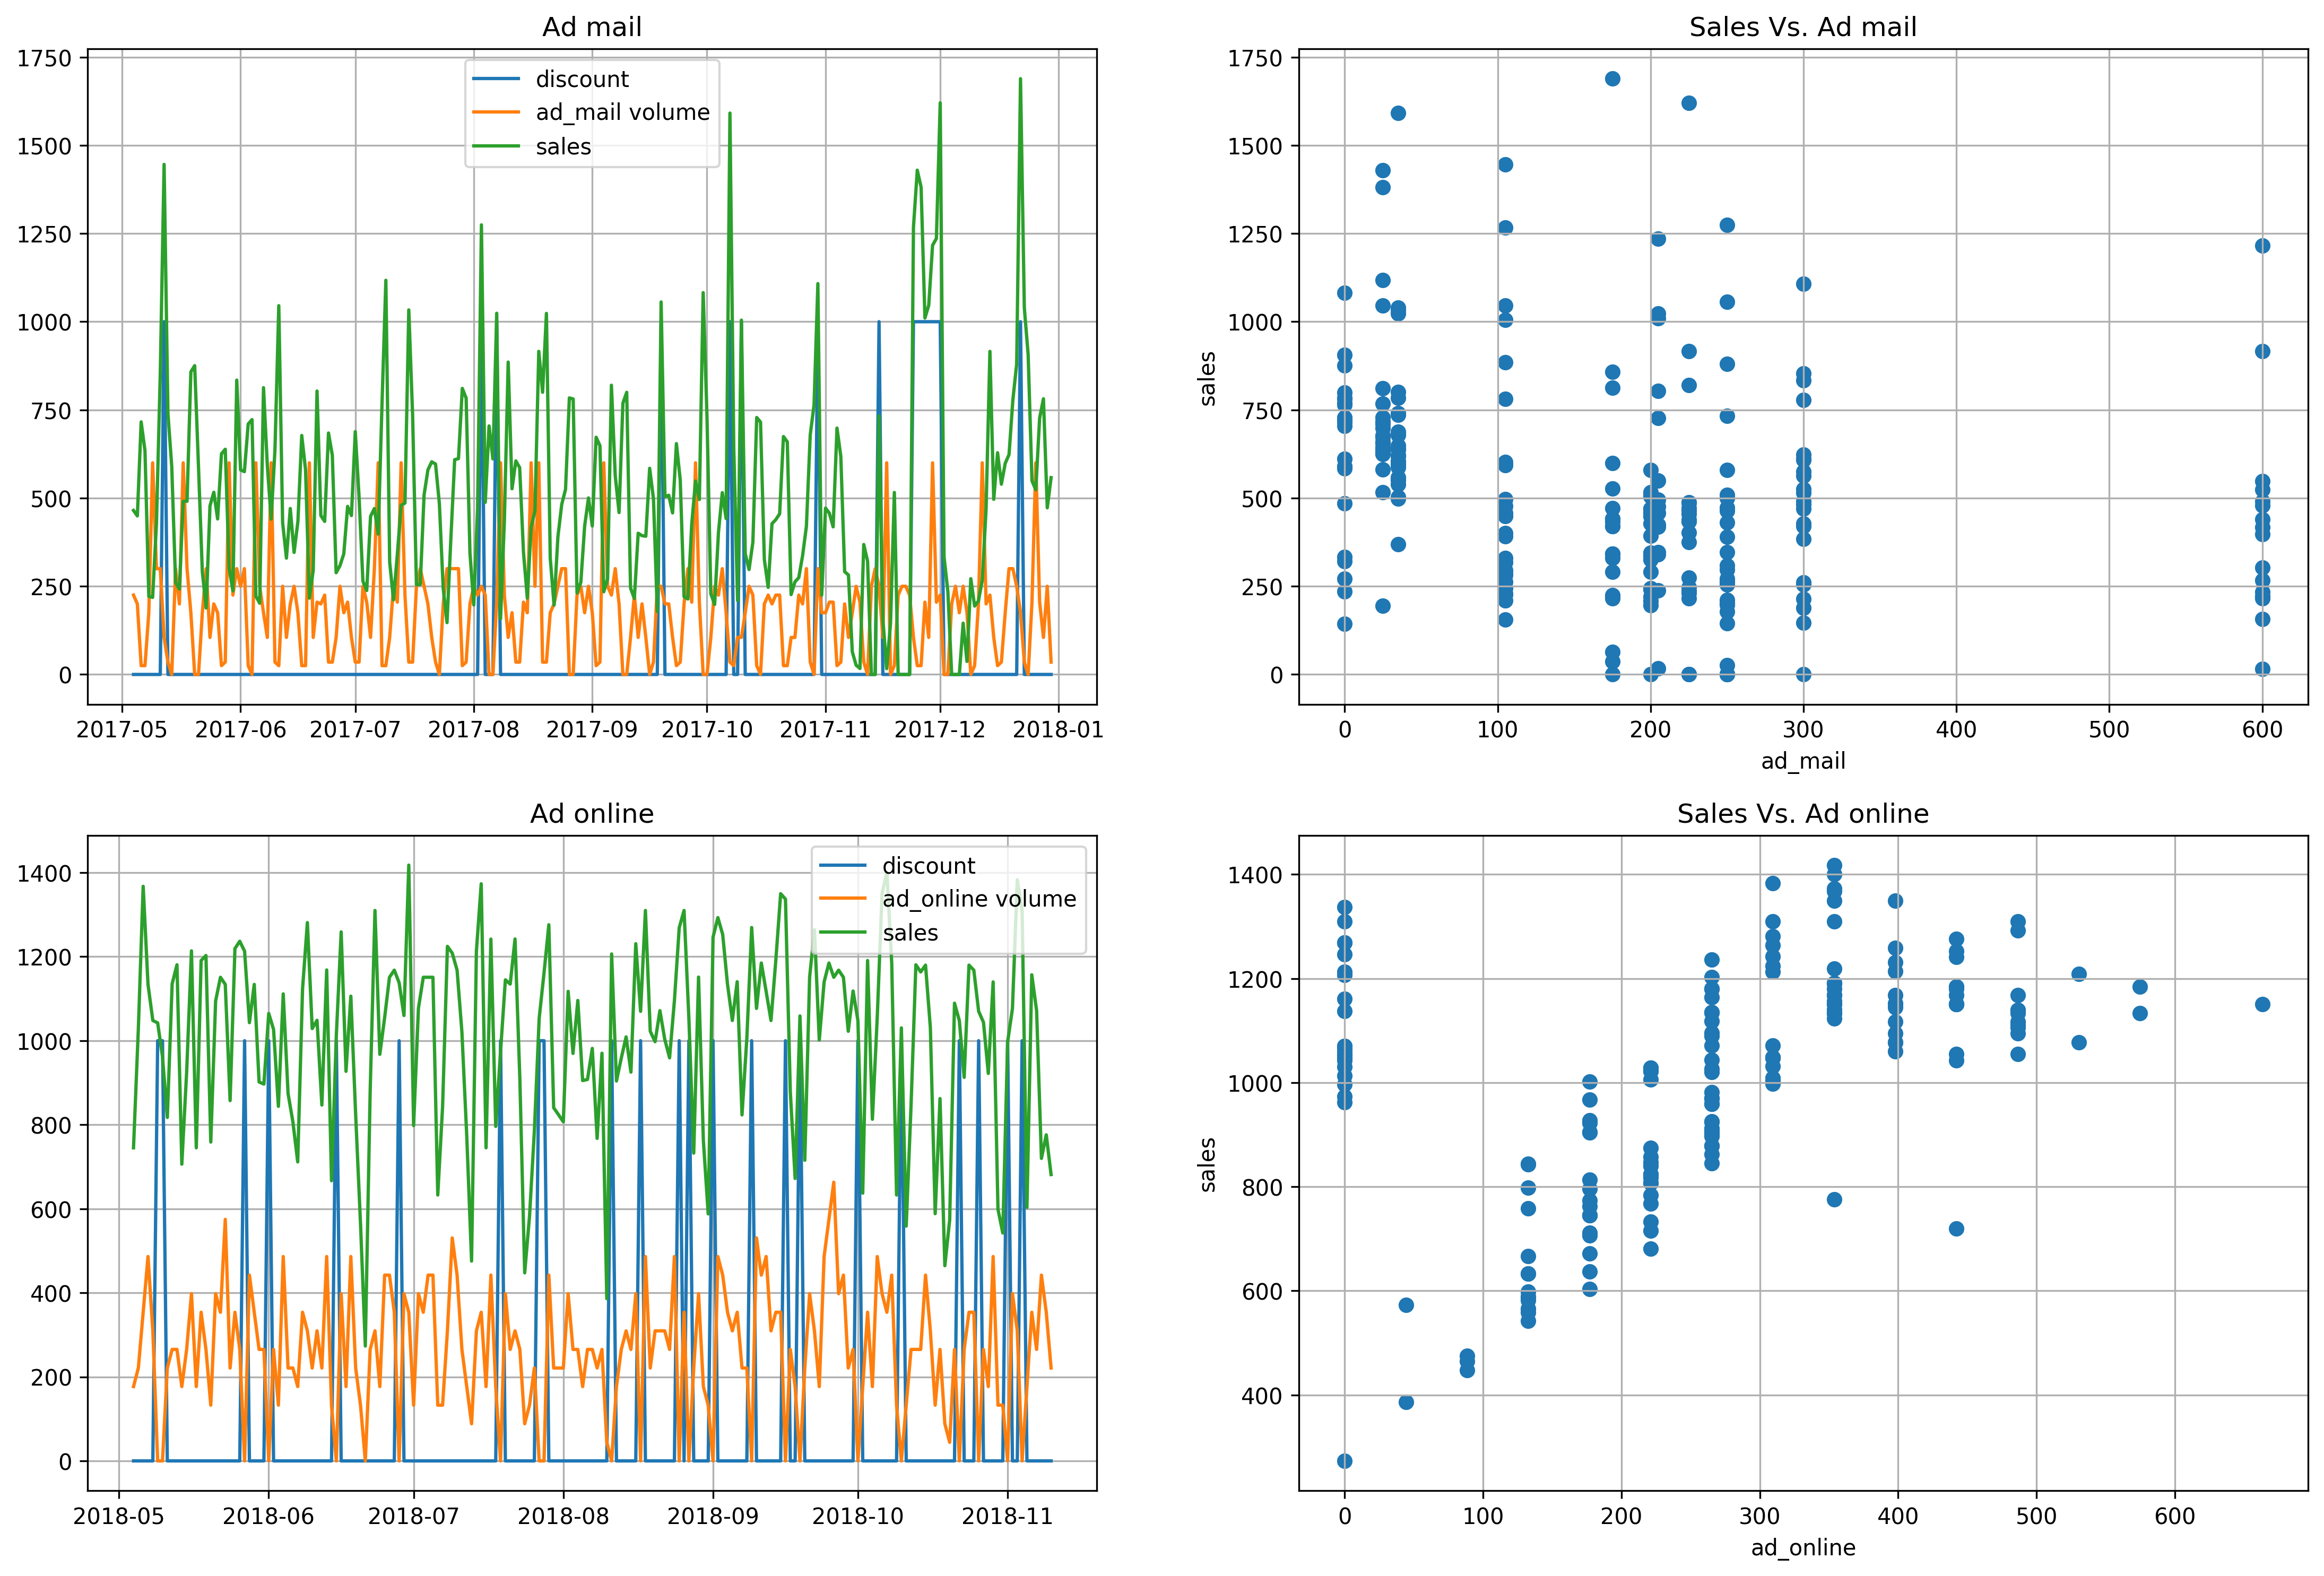

In [9]:
fig, ax = plt.subplots(2, 2)

# We'll amplify discount so that it is in scale with the
# rest of the data for visualization
ax[0, 0].plot(ads_sales_data_mailing['discount'] * 1000, label='discount')
ax[0, 0].plot(ads_sales_data_mailing['ad_mail'], label='ad_mail volume')
ax[0, 0].plot(ads_sales_data_mailing['sales'], label='sales')
ax[0, 0].set_title('Ad mail')
ax[0, 0].grid()
ax[0, 0].legend()

ax[0, 1].scatter(
    ads_sales_data_mailing['ad_mail'], 
    ads_sales_data_mailing['sales']
)
ax[0, 1].set_xlabel('ad_mail')
ax[0, 1].set_ylabel('sales')
ax[0, 1].set_title('Sales Vs. Ad mail')
ax[0, 1].grid()

ax[1, 0].plot(ads_sales_data_online['discount'] * 1000, label='discount')
ax[1, 0].plot(ads_sales_data_online['ad_online'], label='ad_online volume')
ax[1, 0].plot(ads_sales_data_online['sales'], label='sales')
ax[1, 0].set_title('Ad online')
ax[1, 0].grid()
ax[1, 0].legend()

ax[1, 1].scatter(
    ads_sales_data_online['ad_online'], 
    ads_sales_data_online['sales']
)
ax[1, 1].set_xlabel('ad_online')
ax[1, 1].set_ylabel('sales')
ax[1, 1].set_title('Sales Vs. Ad online')
ax[1, 1].grid()

plt.show();

In [10]:
ads_sales_data_mailing[['ad_mail', 'sales']].corr()

ad_mail     sales
ad_mail  1.000000 -0.278408
sales   -0.278408  1.000000

There is negative correlation between amount of ad volume through mail and sales

In [11]:
ads_sales_data_online[['ad_online', 'sales']].corr()

ad_online     sales
ad_online   1.000000  0.443007
sales       0.443007  1.000000

There is a positive correlation between amount of ad volume through online sources and sales

---
# Ad Mailing

Offline channel of ad delivery

### Do Discounts Help?
We see that on some days, the company has deployed a discount. We're interested in whether this `discount` actually has an impact on `sales`.

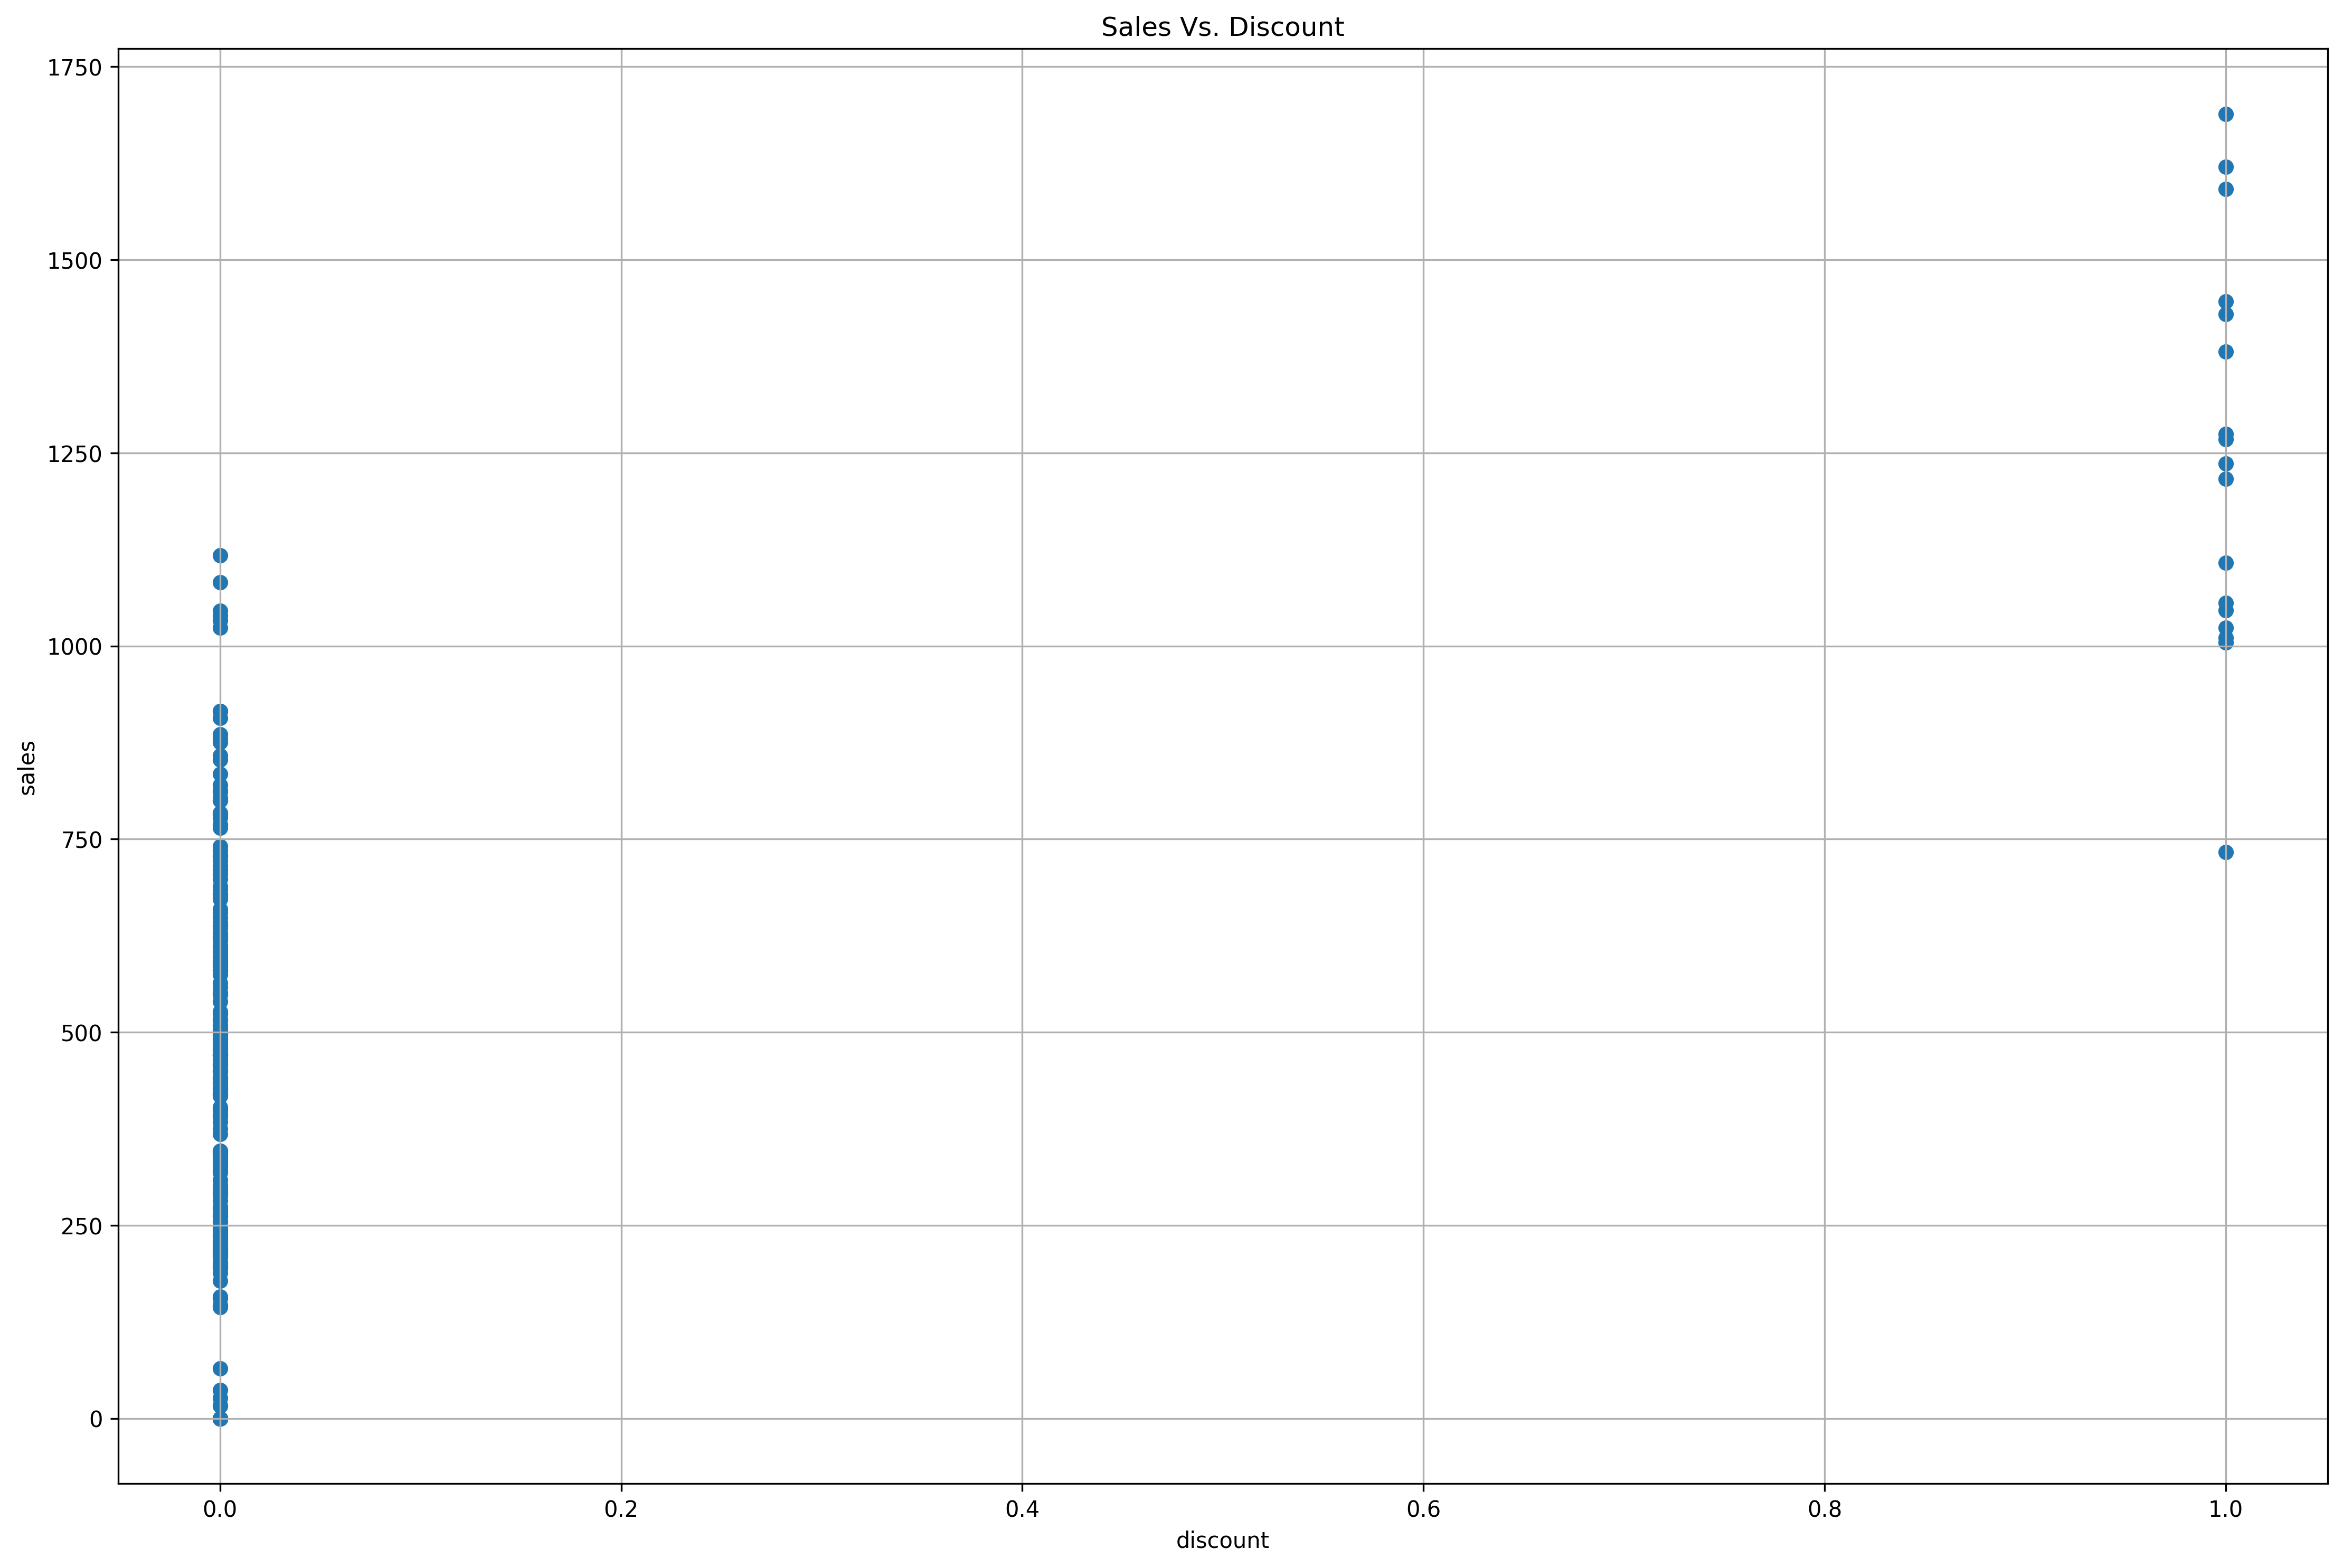

In [12]:
fig, ax = plt.subplots(1, 1)
ax.scatter(ads_sales_data_mailing['discount'], ads_sales_data_mailing['sales'])
ax.set_xlabel('discount')
ax.set_ylabel('sales')
ax.grid()
ax.set_title('Sales Vs. Discount')
plt.show();

Let's see how many sample of sales with discount and without discount we have.

In [13]:
sales_no_discount = ads_sales_data_mailing['sales'][ads_sales_data_mailing['discount'] == 0.0]
sales_with_discount = ads_sales_data_mailing['sales'][ads_sales_data_mailing['discount'] == 1.0]

print('Number of Days (With Discount): {} \nNumber of Days (Without Discount): {}'.format(
    sales_with_discount.count(), 
    sales_no_discount.count()
))

Number of Days (With Discount): 17 
Number of Days (Without Discount): 224


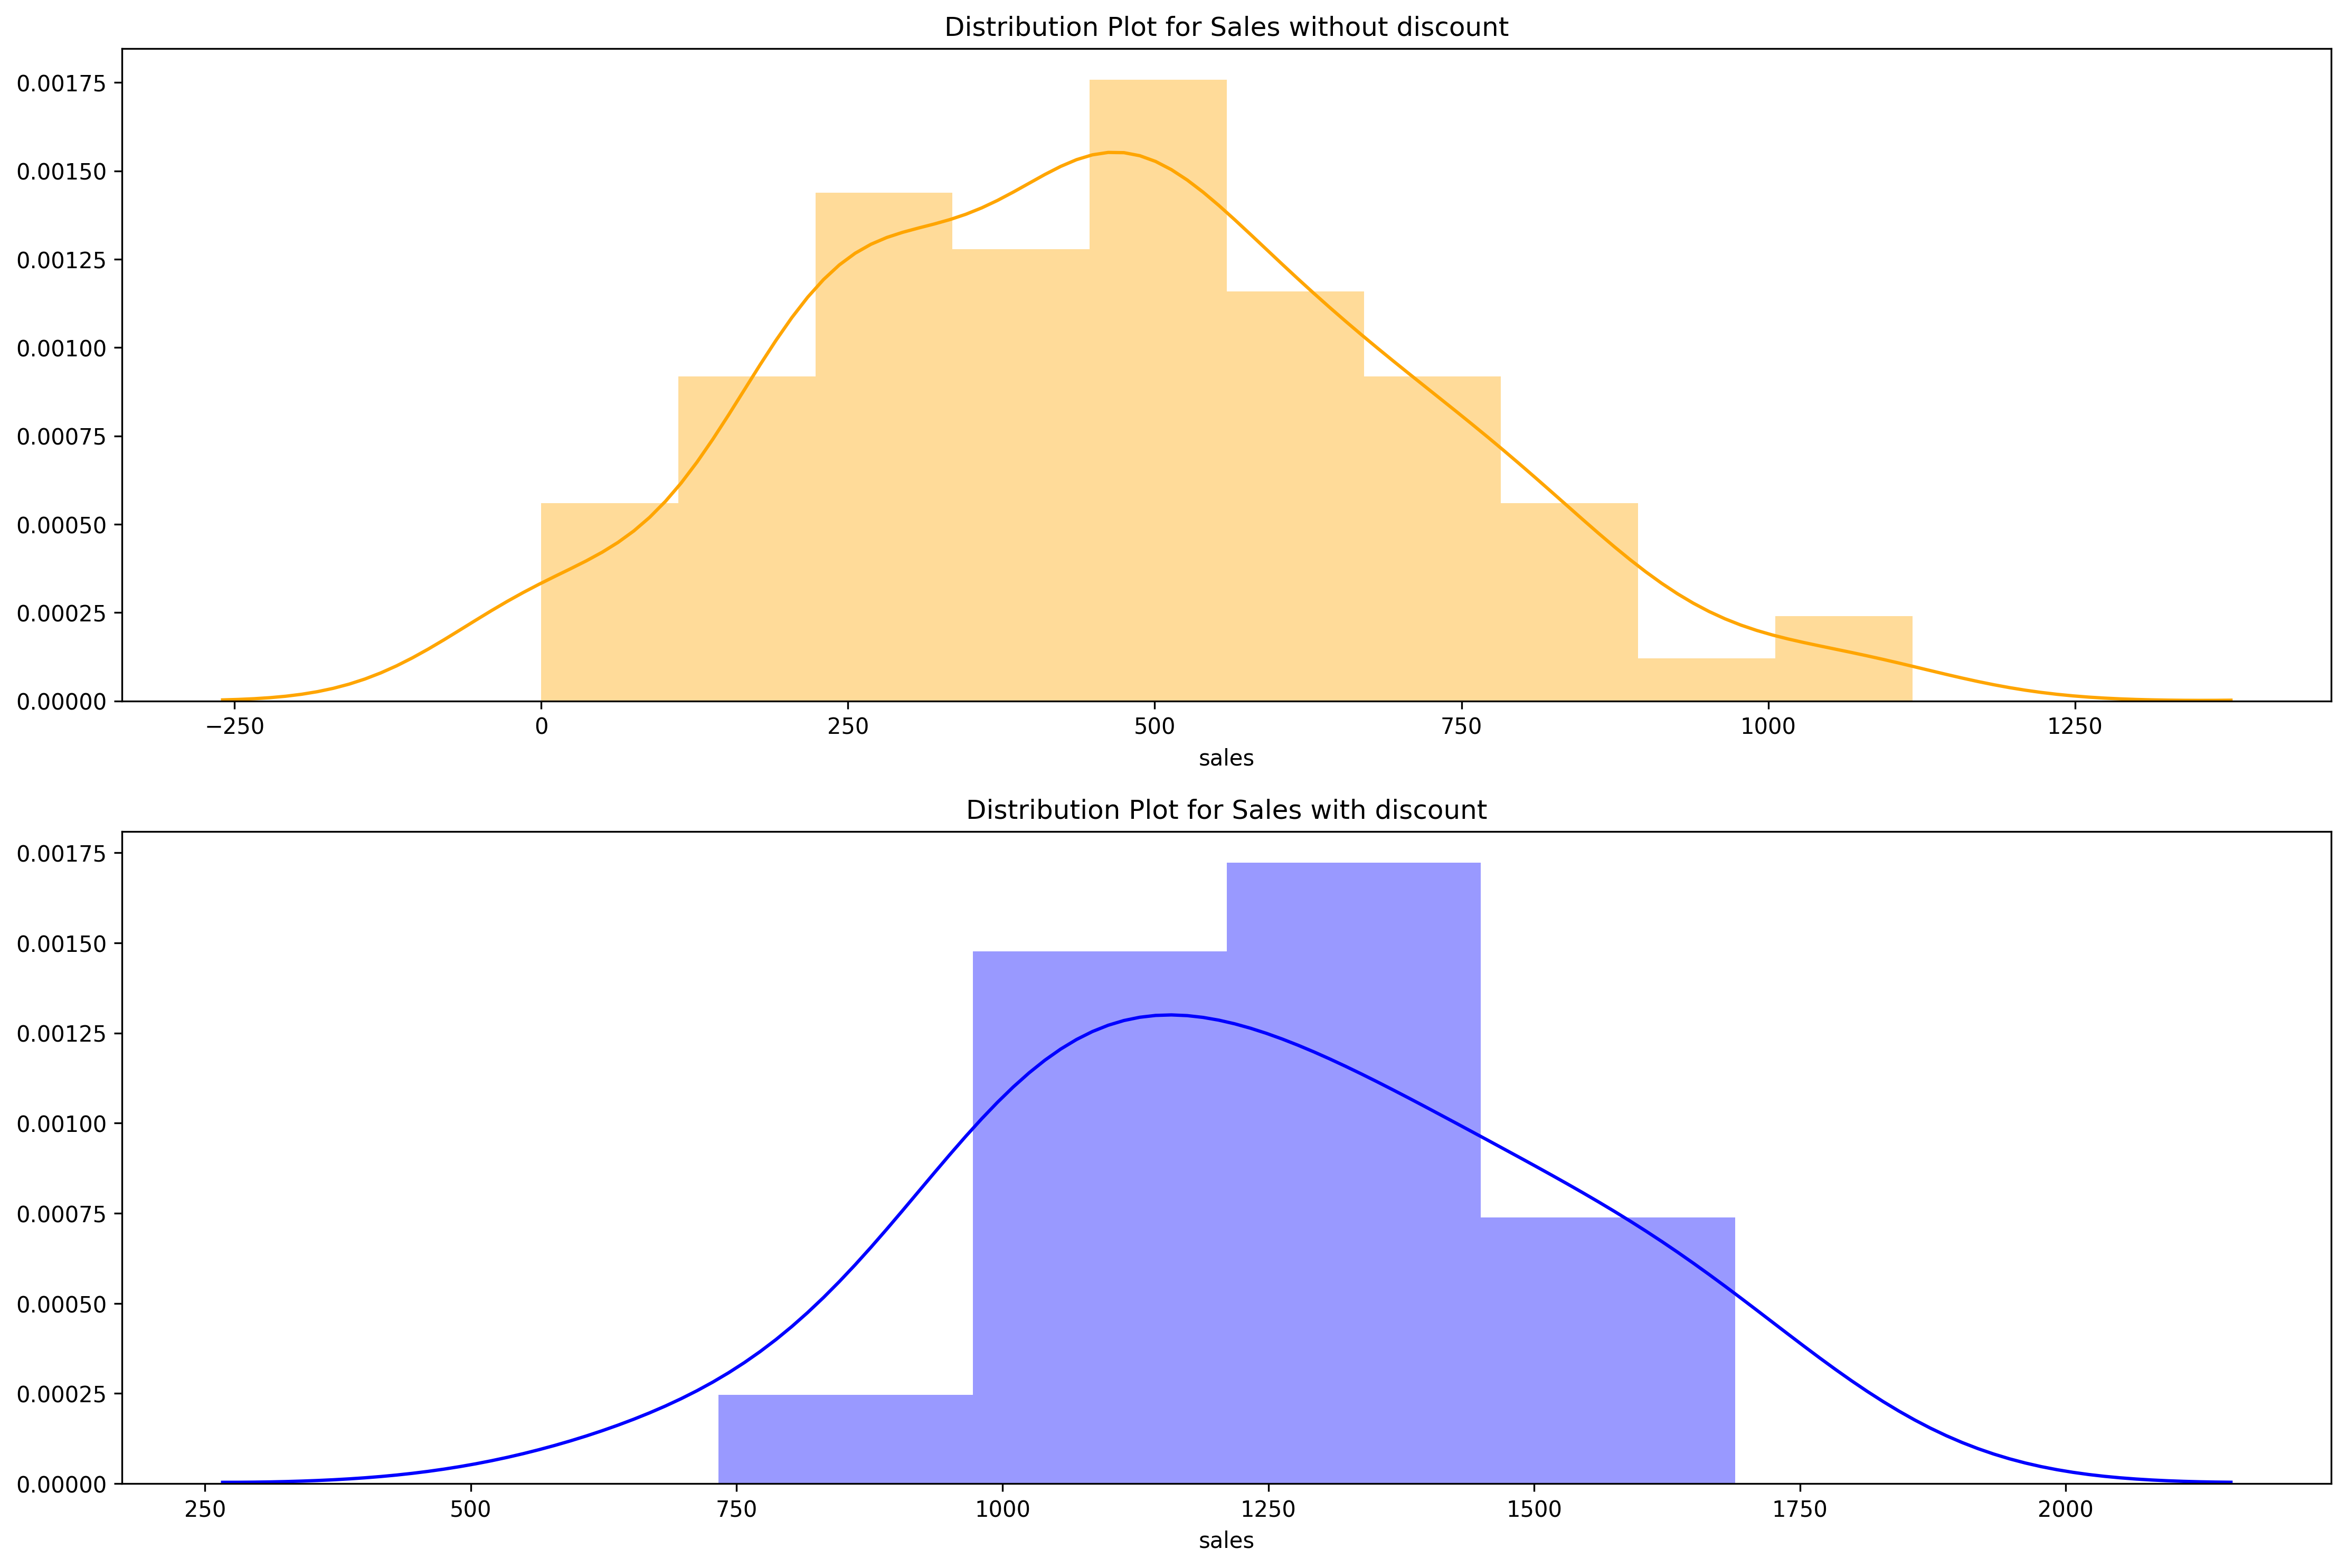

In [14]:
fig, ax = plt.subplots(2, 1)
sns.distplot(sales_no_discount, ax=ax[0], color='orange')
ax[0].set_title('Distribution Plot for Sales without discount')
sns.distplot(sales_with_discount, ax=ax[1], color='blue')
ax[1].set_title('Distribution Plot for Sales with discount')
plt.show();

In [15]:
mean_sales_no_discount = sales_no_discount.mean()
mean_sales_with_discount = sales_with_discount.mean()

print('Mean Sales (With Discount): ${} \nMean Sales (Without Discount): ${}'.format(
    round(mean_sales_with_discount, 2), 
    round(mean_sales_no_discount, 2)
))

Mean Sales (With Discount): $1243.17 
Mean Sales (Without Discount): $463.57


We observe that when the `discount` is applied, there seems to be a significant increase in the `sales`. Let's use a two-sample right-tailed Student's $t$-test to test whether this hypothesis is true at a significance level / false positive rate / Type I error rate of $\alpha = 0.05$.

$$
\begin{aligned}
H_0 &: \mu = \$463.57 \\
H_\alpha &: \mu > \$463.57 \\
\end{aligned}
$$

Let's get the $t$-statistic (Standardized mean).

In [16]:
t_stat = (mean_sales_with_discount - mean_sales_no_discount) \
    / (
        ((sales_with_discount.std() ** 2) / sales_with_discount.count())
        + ((sales_no_discount.std() ** 2) / sales_no_discount.count())
    ) ** 0.5

# Degrees of freedom will just be the
# smaller of the 2 sample sizes
df = min(sales_with_discount.count(), sales_no_discount.count())-1
p_val = 1 - t.cdf(
    t_stat, 
    df=df
)

print('p-value: {}'.format(p_val))

p-value: 9.891333307976424e-10


### Conclusion

Since the $p$-value$ = 9.89 \times 10^{-10} < \alpha = 0.05$, we reject the null hypothesis $H_0$ and suggests that there is a statistically significant increase in the mean `sales` comparing \\$463.57 and \\$1243.17.

### Error Trend Seasonality Decompose
Let's see what else we can discover from the data like patterns and insights.

In [17]:
ad_mail_sales_decomposed = tsa.seasonal_decompose(ads_sales_data_mailing[['ad_mail', 'sales']]);

Let's take a look at the seasonal pattern.

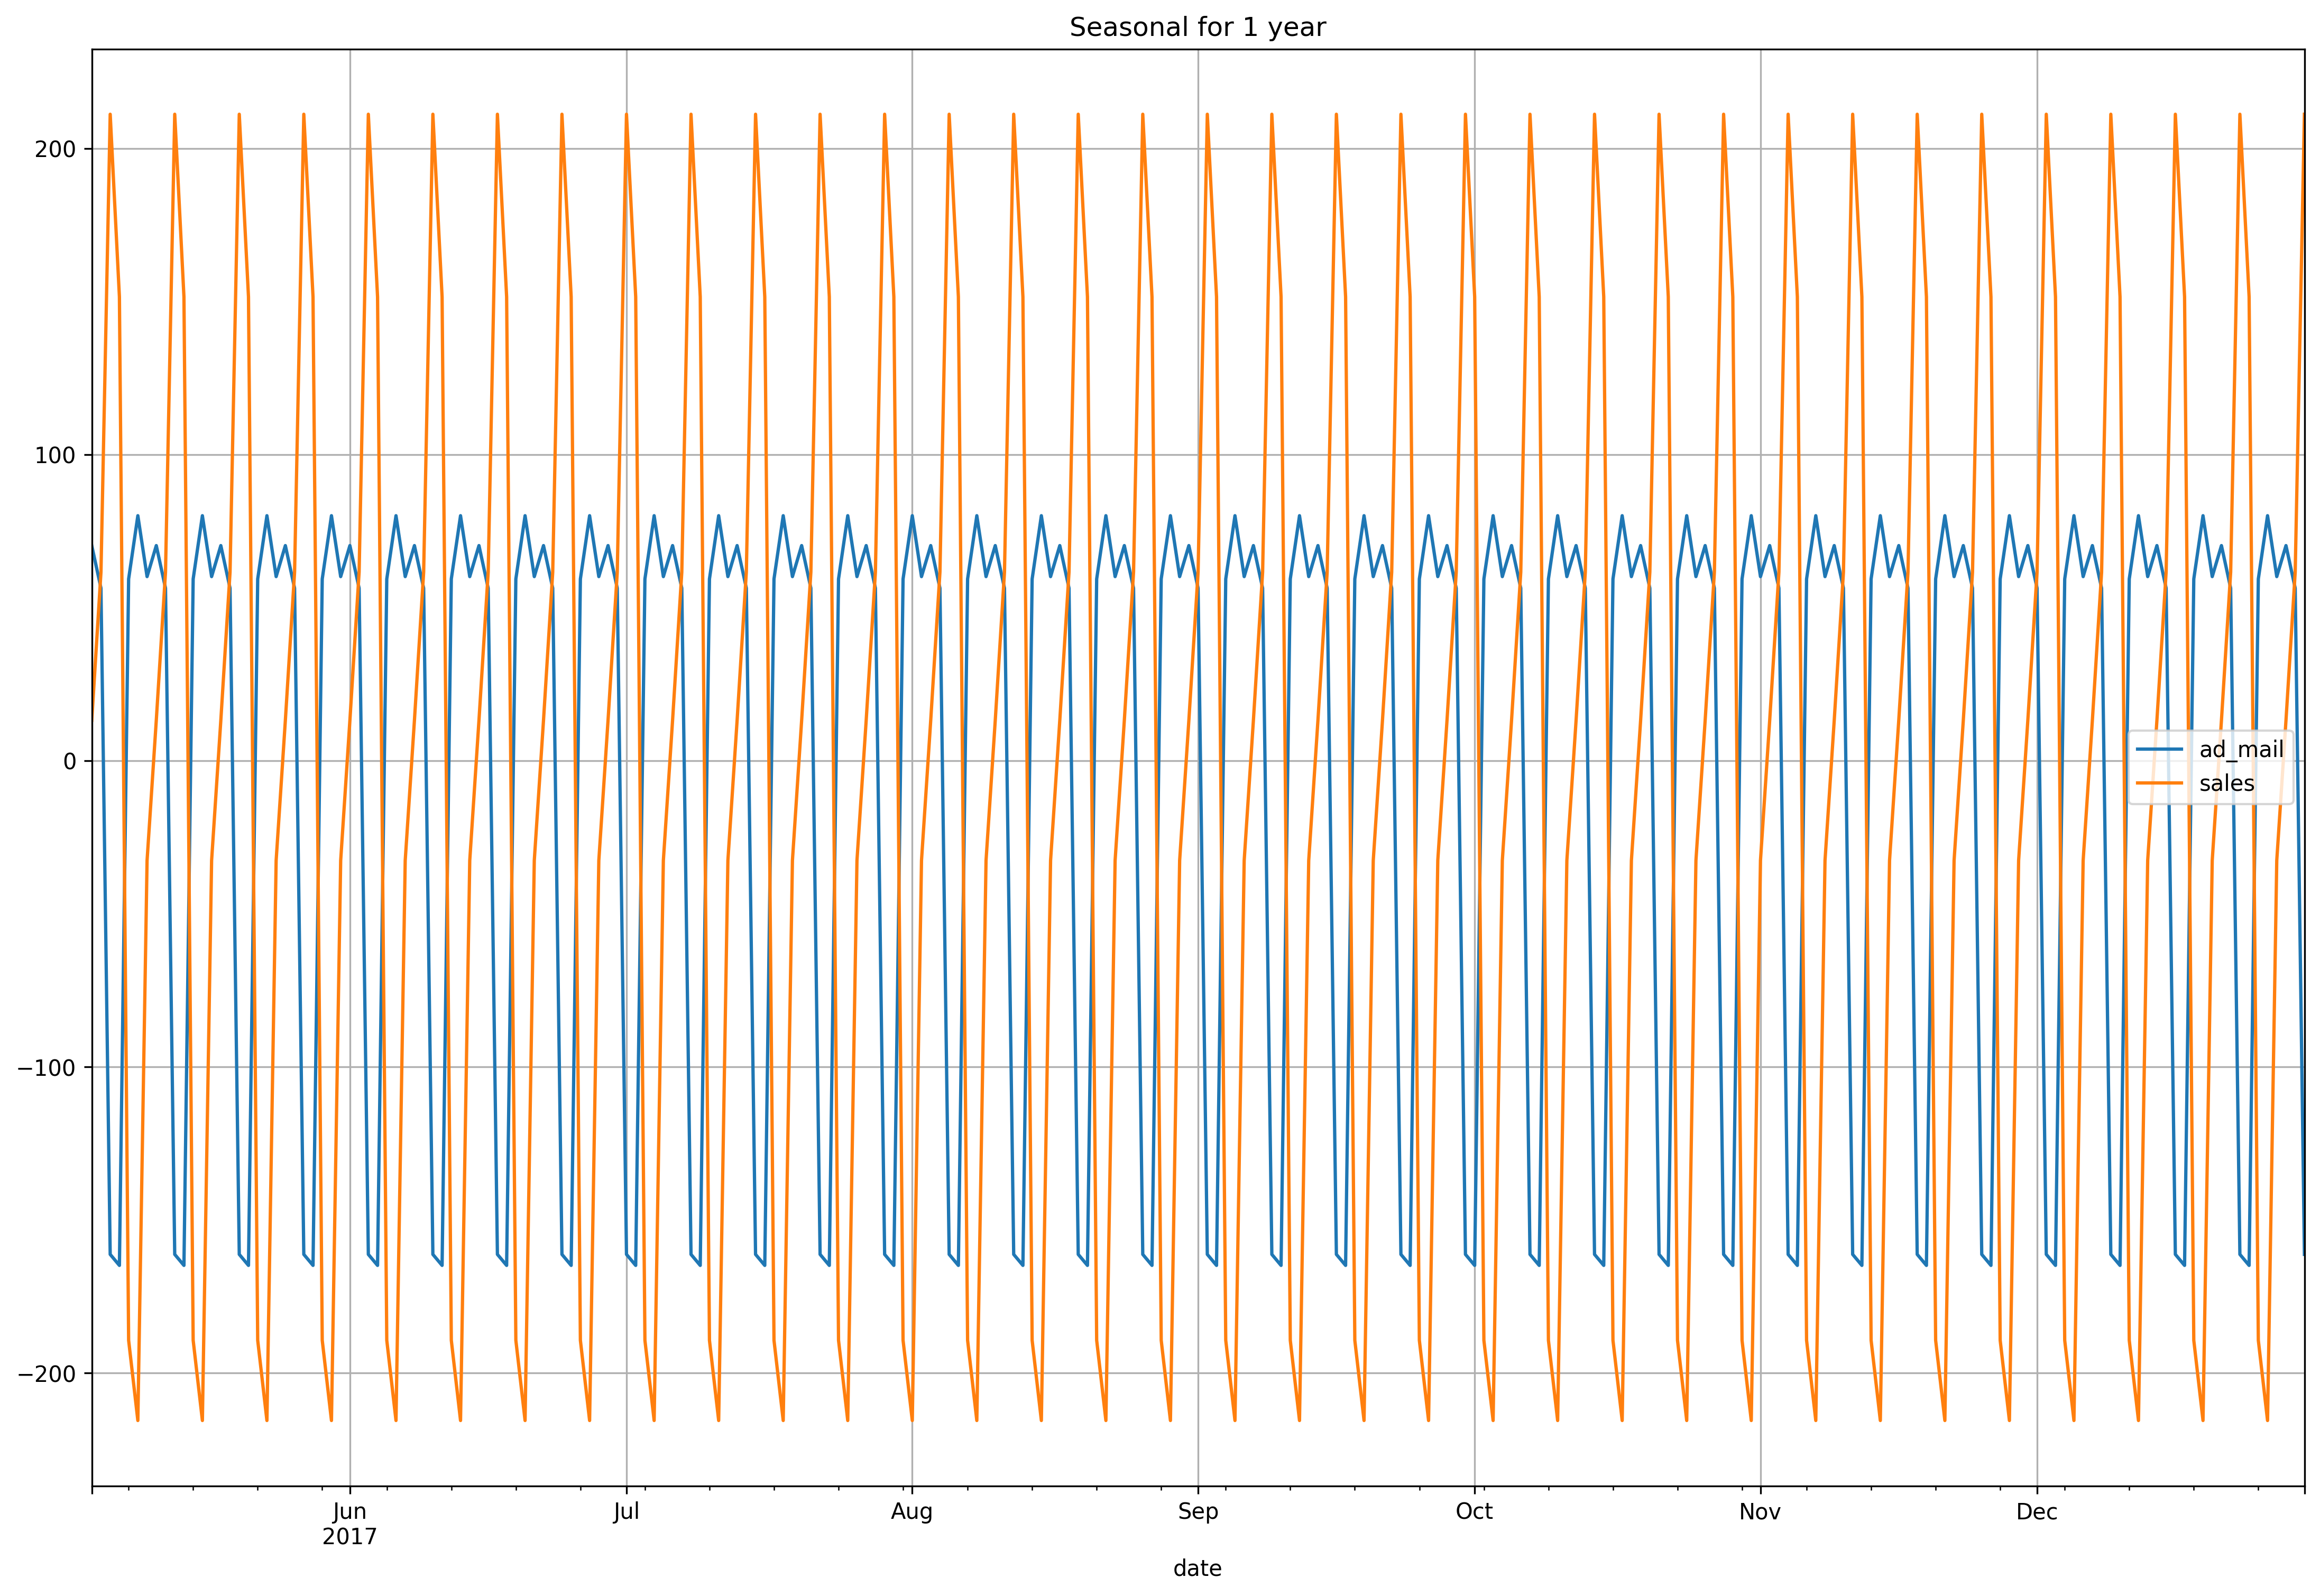

In [18]:
ad_mail_sales_decomposed.seasonal.plot().grid()
plt.title('Seasonal for 1 year');

Let's zoom in into looking at the seasonality in a month.

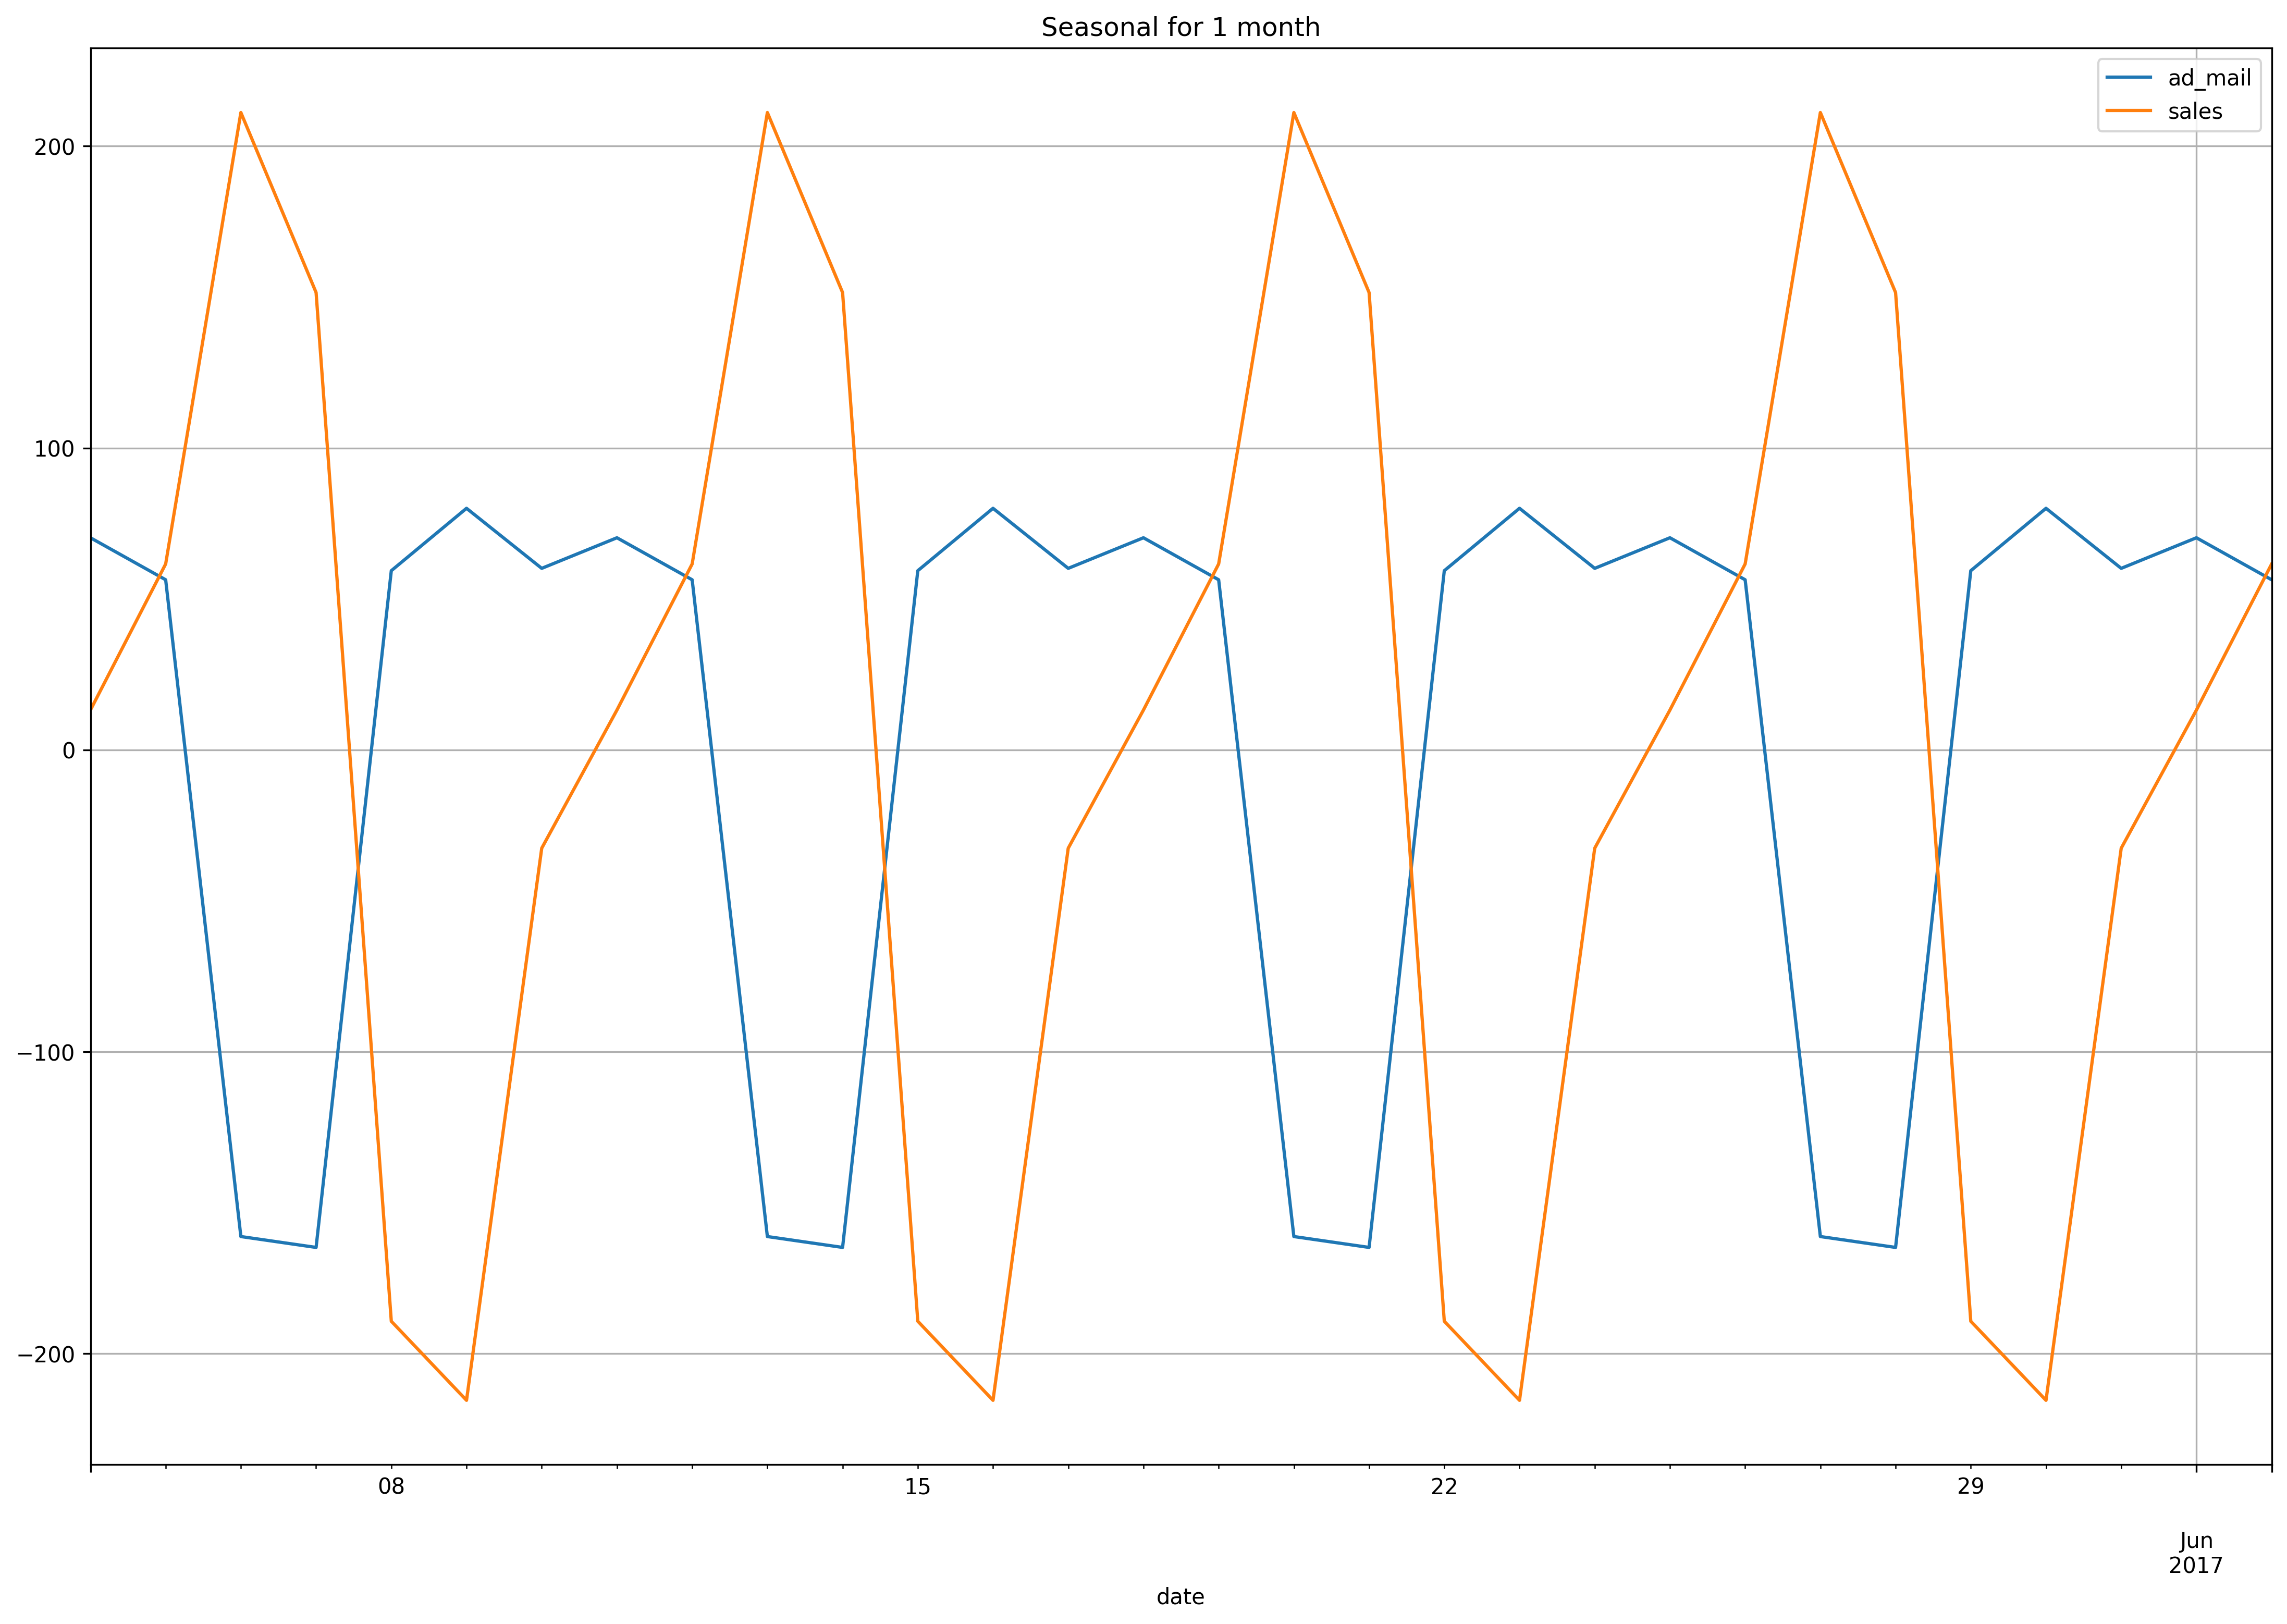

In [19]:
ad_mail_sales_decomposed.seasonal[:30].plot().grid()
plt.title('Seasonal for 1 month');

We observe that whenever `ad_mail` increases, `sales` decreases. But that doesn't make sense! Why is that? It might be that there's a lag between when `ad_mail` is deployed and when consumers actually get the ad. Let's explore how big this lag is.

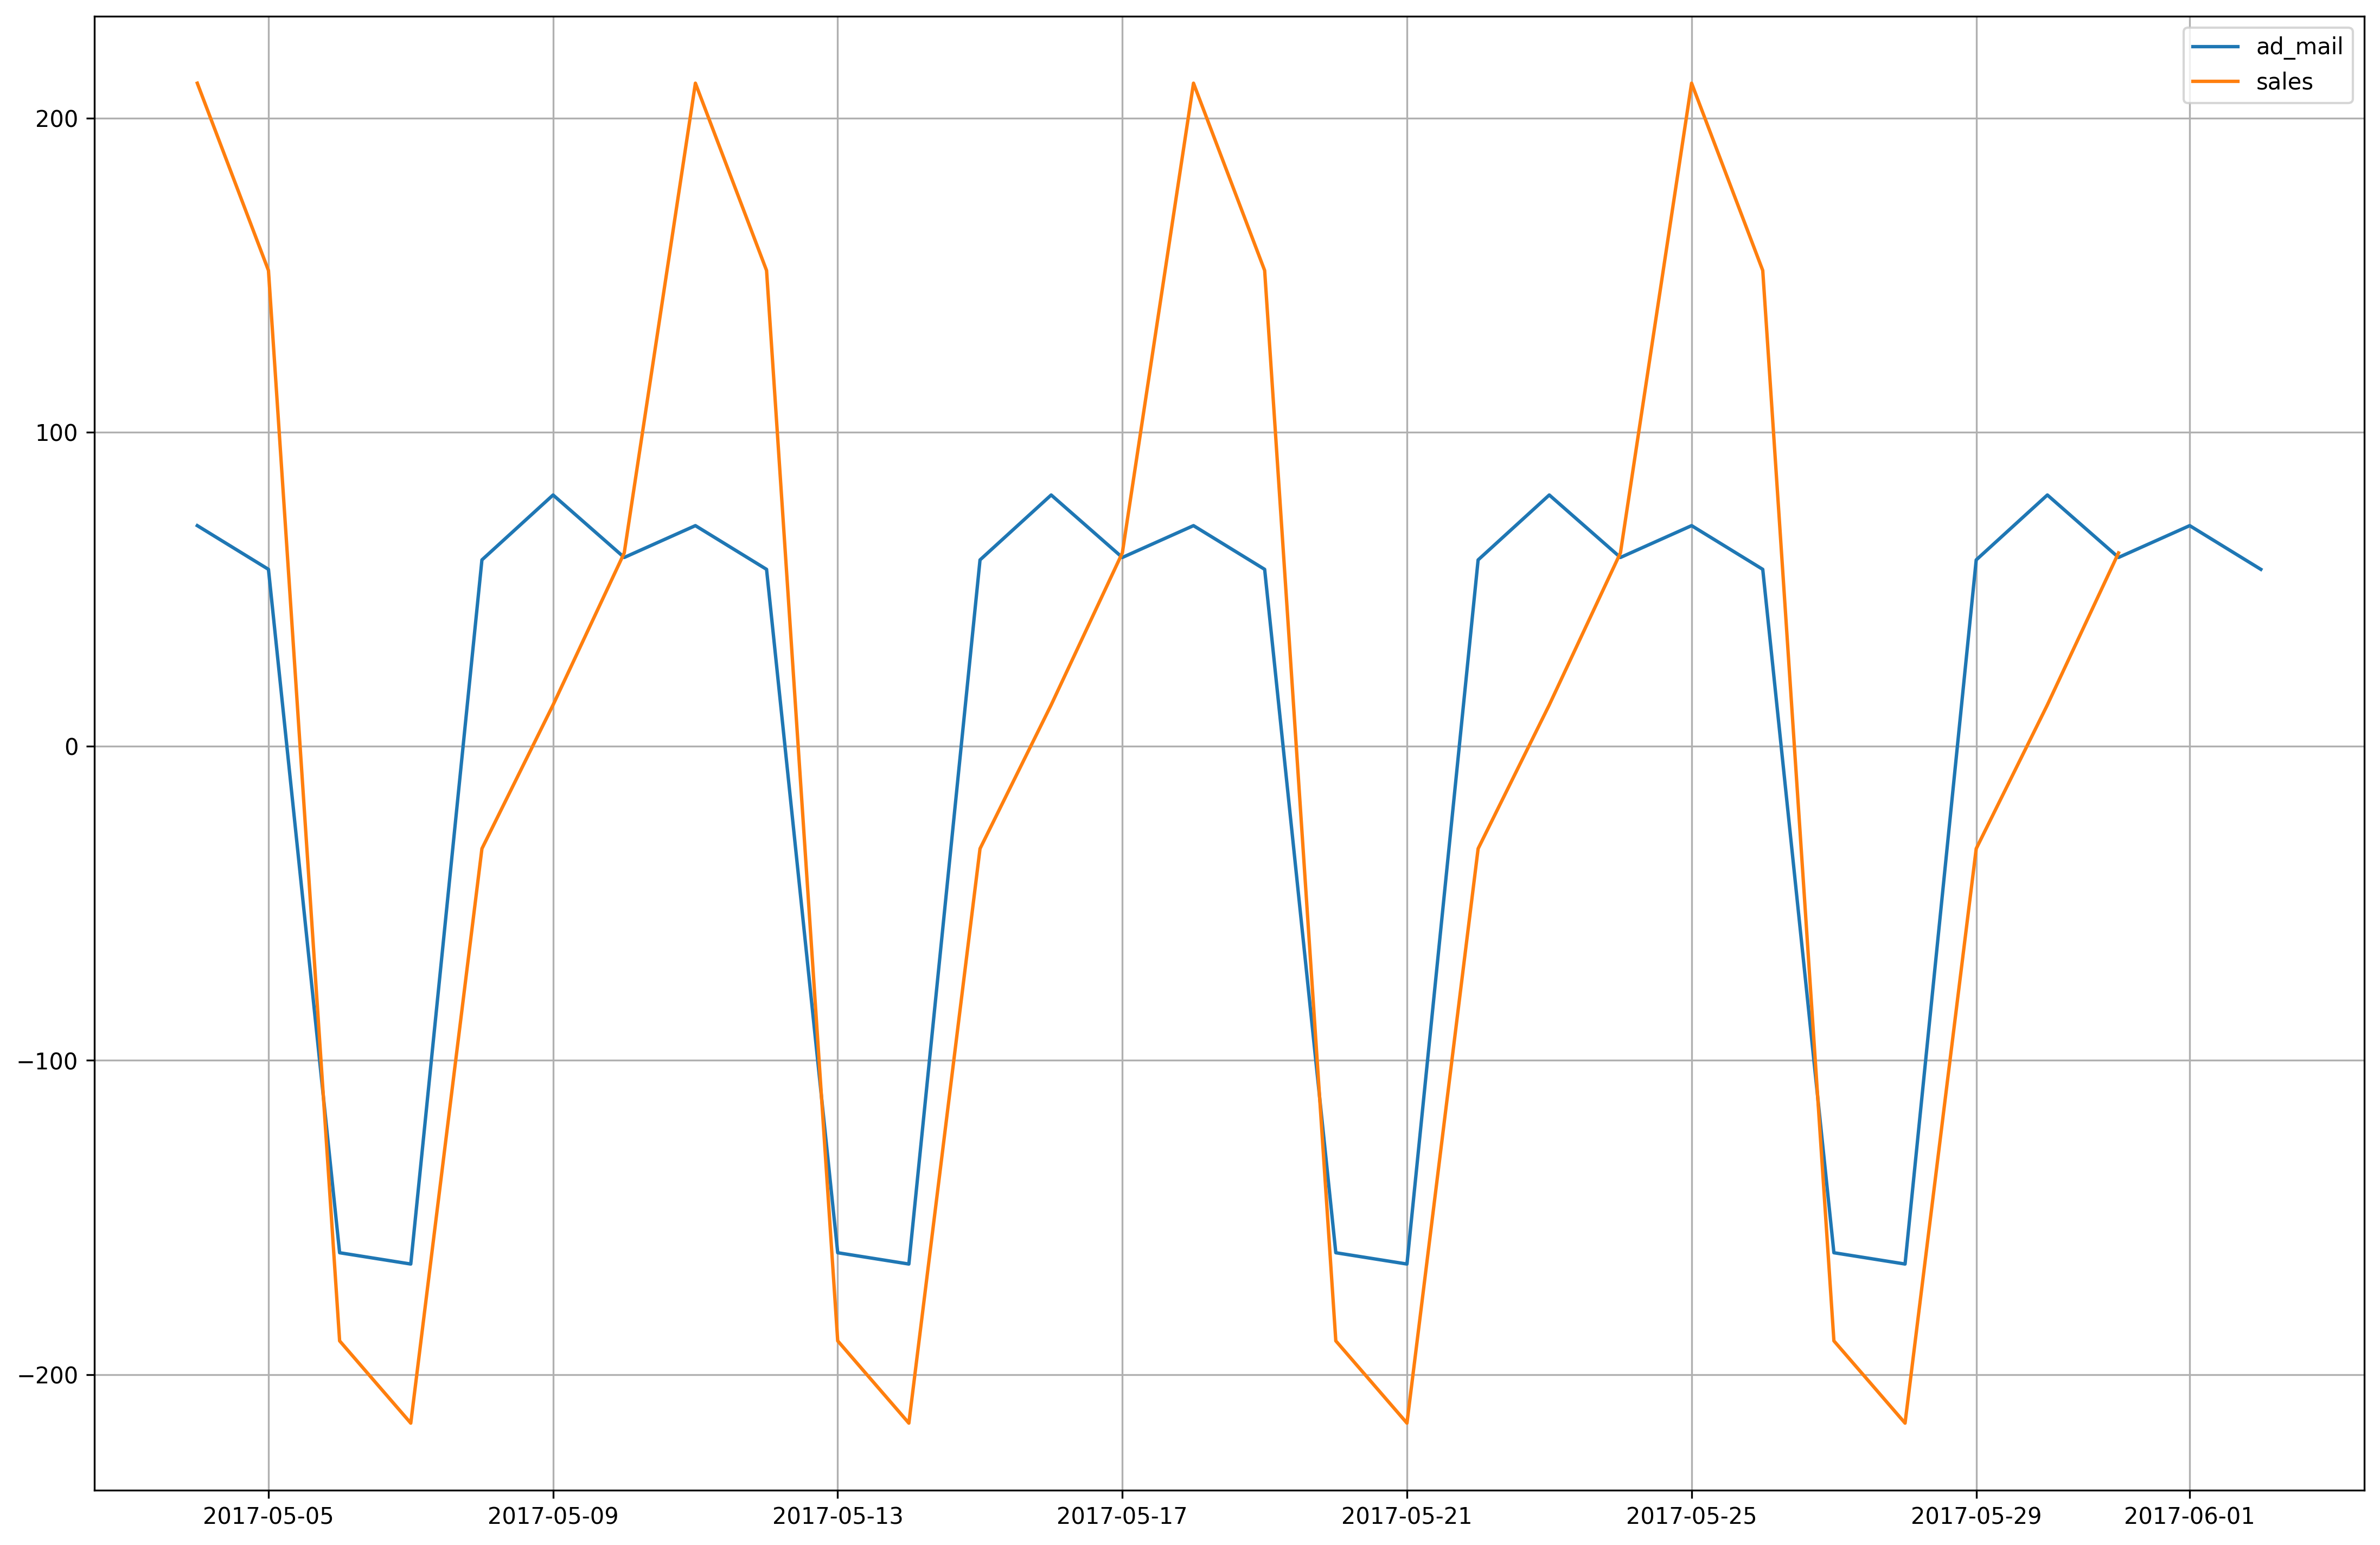

In [20]:
plt.plot(ad_mail_sales_decomposed.seasonal[:30]['ad_mail'], label='ad_mail')
plt.plot(ad_mail_sales_decomposed.seasonal[:30]['sales'].shift(-2), label='sales')
plt.legend()
plt.grid()
plt.show();

Seems like a shift of about 2 days +/- aligns our peaks and troughs, meaning that there is approximately a 2 day lag between when an ad is launched by the company as well as when it actually takes effect on the consumers. Let's now fit a [simple linear regression (Ordinary Least Squares solution / line)](https://en.wikipedia.org/wiki/Simple_linear_regression) to the new data (with sales shifted into the future by 2 days) and try to interpret it.

We see now that there is indeed a positive correlation, let's look at how much they are correlated now.

In [22]:
ads_sales_data_mailing_with_sales_2_days_in_future = pd.concat([
    ads_sales_data_mailing['ad_mail'],
    ads_sales_data_mailing['sales'].shift(-2)
], axis=1)

ads_sales_data_mailing_with_sales_2_days_in_future.corr()

ad_mail     sales
ad_mail  1.000000  0.546316
sales    0.546316  1.000000

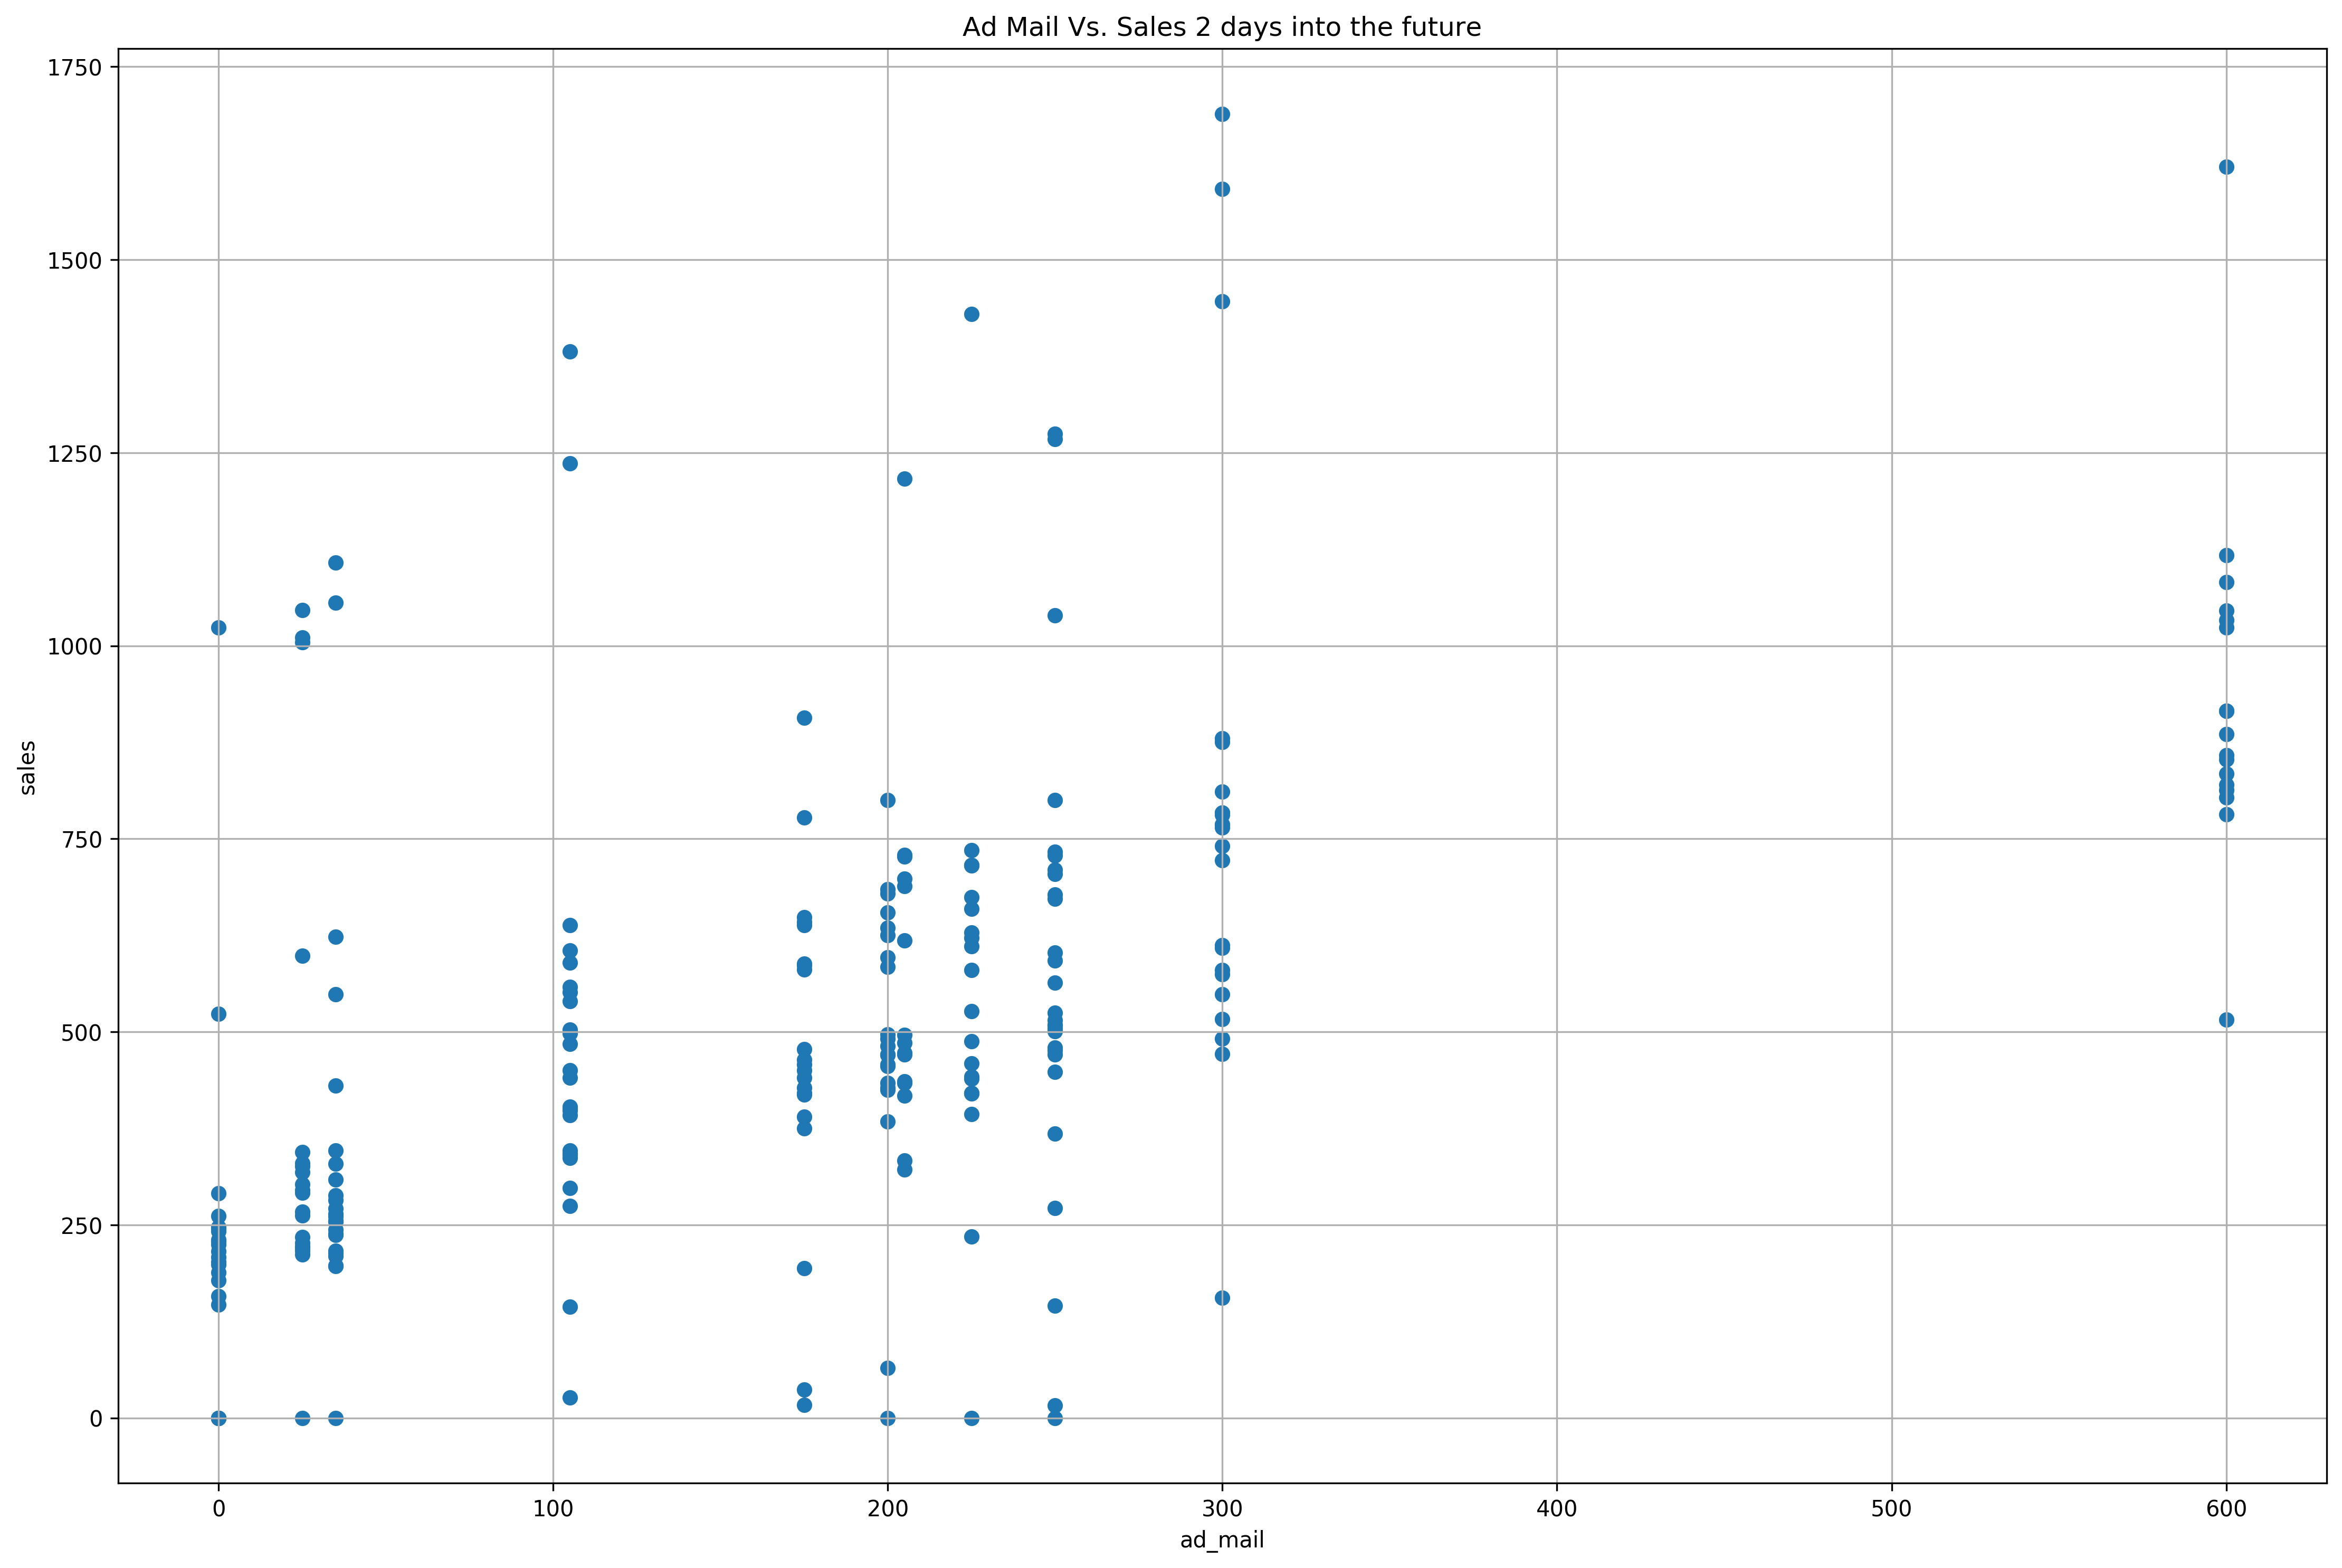

In [23]:
fig, ax = plt.subplots(1, 1)
ax.scatter(
    ads_sales_data_mailing_with_sales_2_days_in_future['ad_mail'],
    ads_sales_data_mailing_with_sales_2_days_in_future['sales']
)
ax.set_xlabel('ad_mail')
ax.set_ylabel('sales')
ax.grid()
ax.set_title('Ad Mail Vs. Sales 2 days into the future')
plt.show();

$\rho = 0.55$, a reasonable level of correlation between `ad_mail` and `sales`, let's find the OLS solution ("best fit line"), AKA:

$$
\hat{\mathbf{y}} = r\frac{s_y}{s_x}\mathbf{x} + (\bar{y} - r\frac{s_y}{s_x}\bar{x})
$$

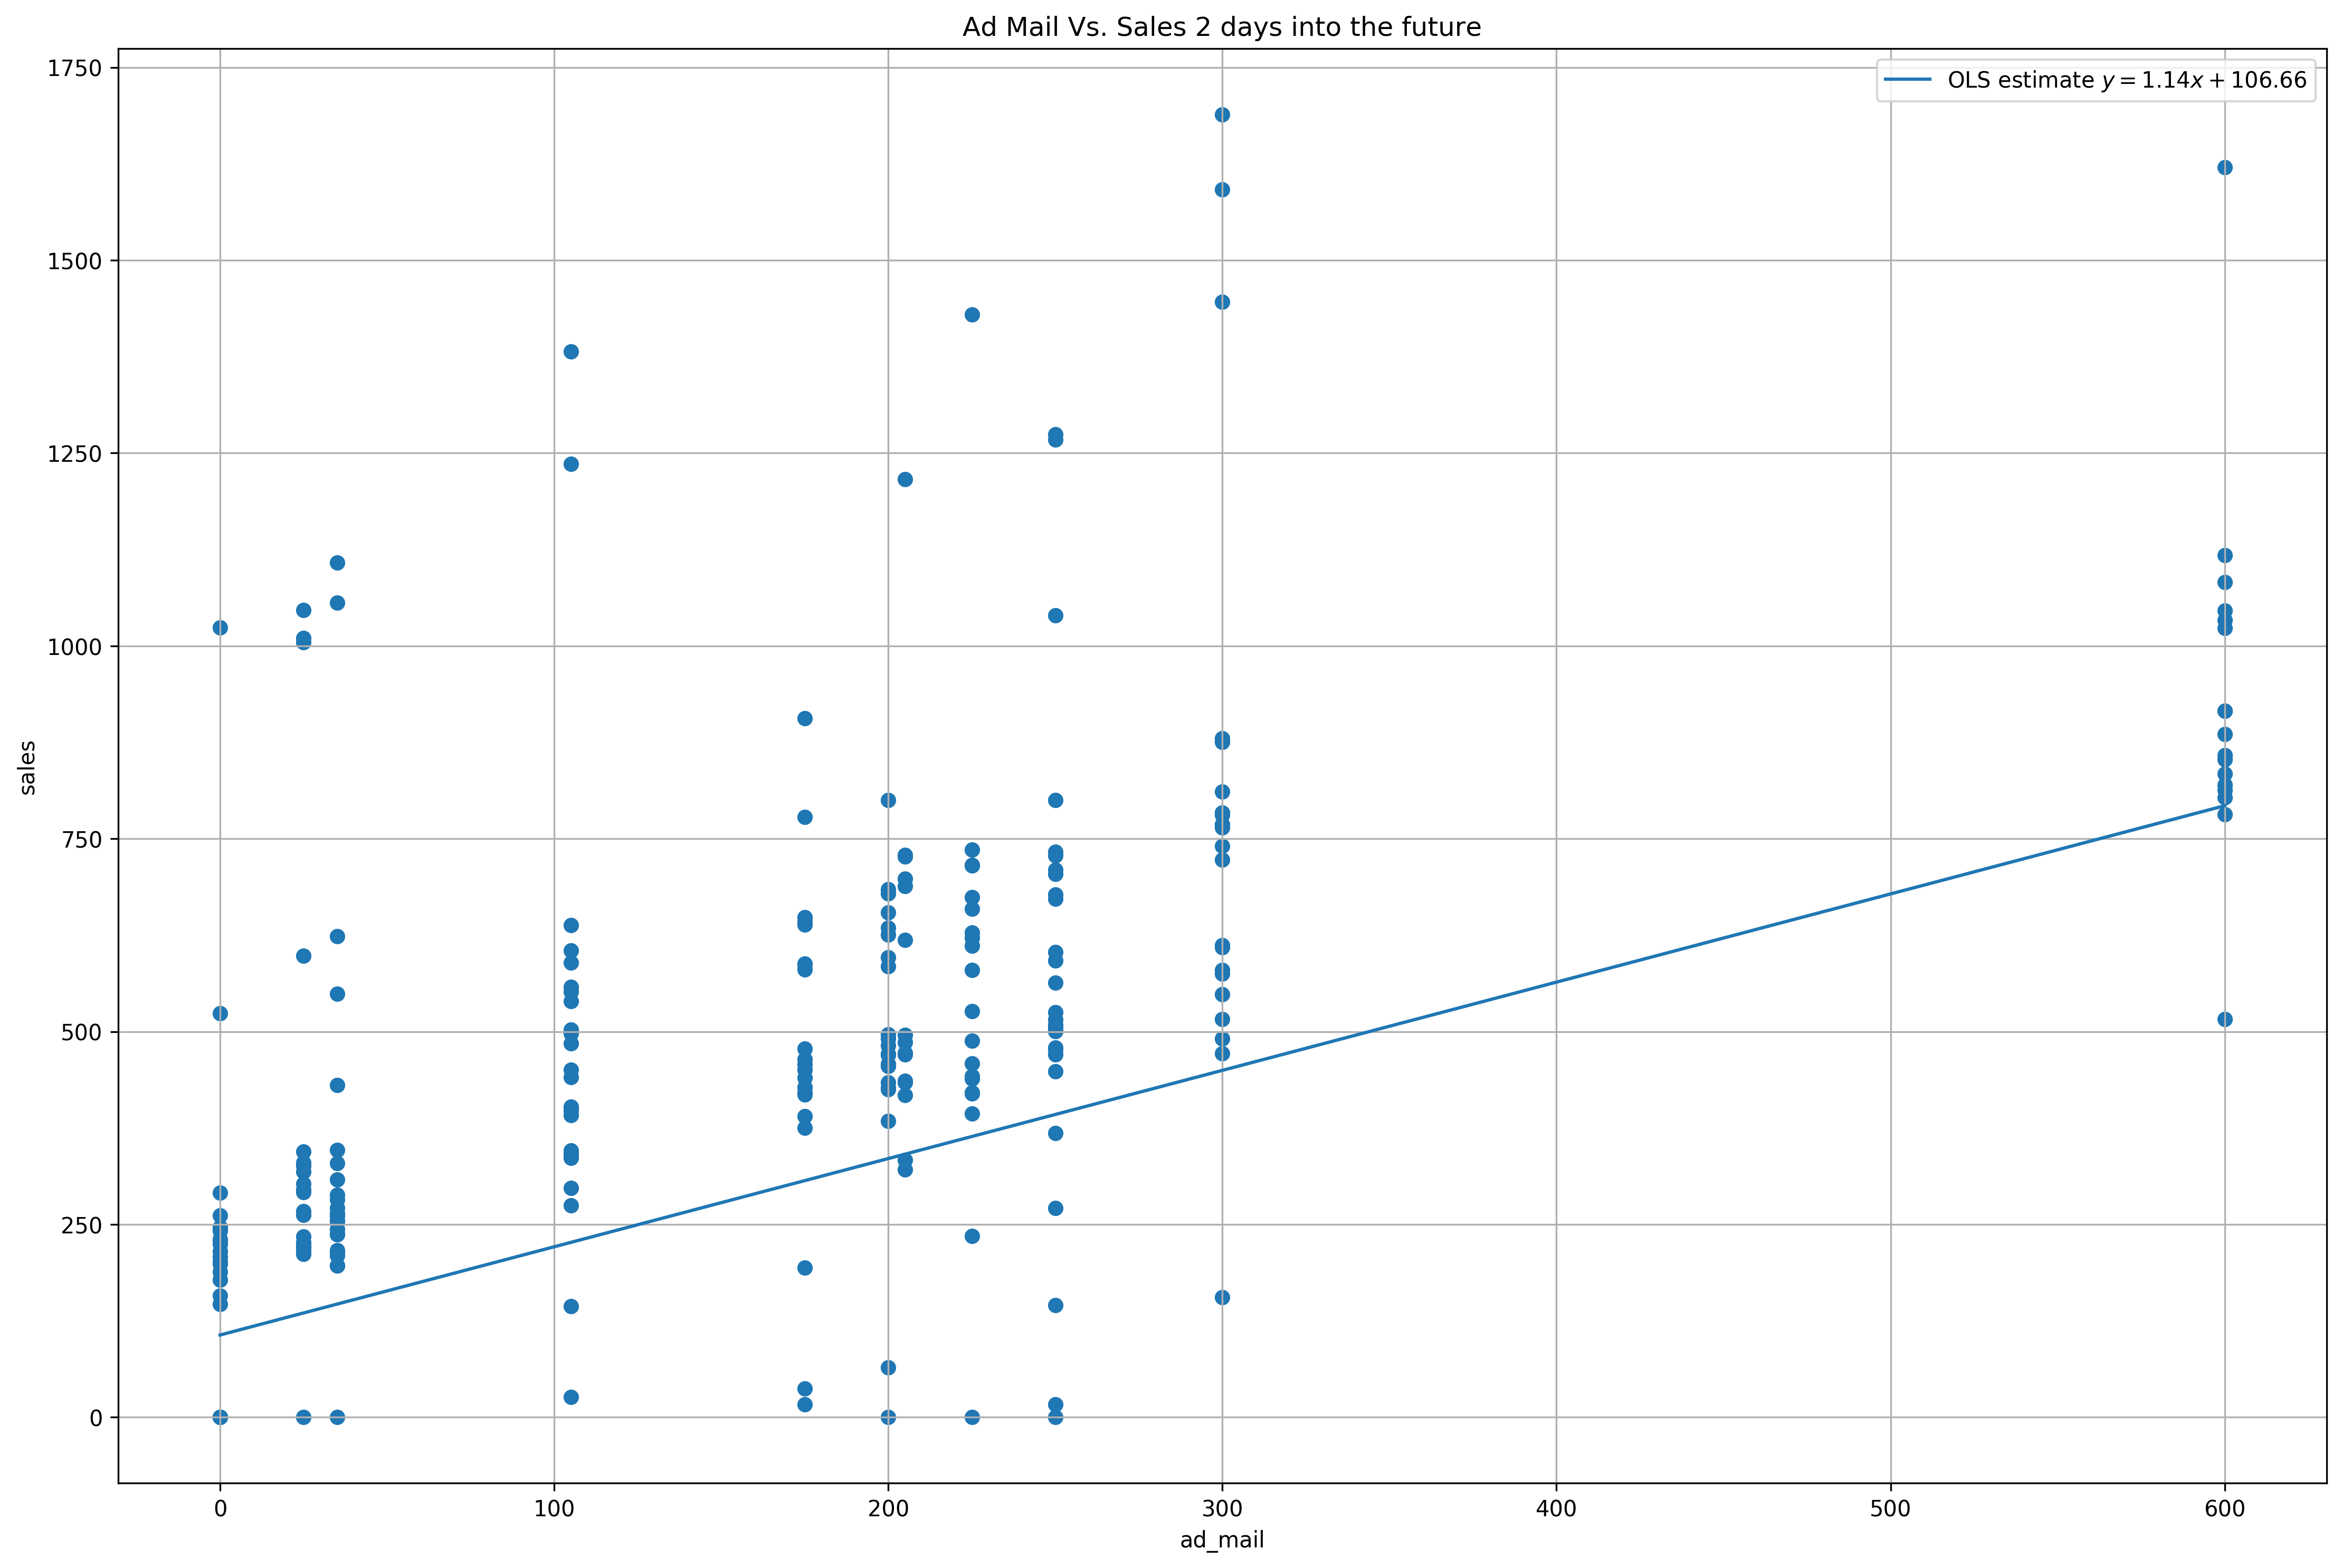

In [24]:
r = ads_sales_data_mailing_with_sales_2_days_in_future.corr().iloc[0, 1]
s_y = ads_sales_data_mailing_with_sales_2_days_in_future['sales'].std()
s_x = ads_sales_data_mailing_with_sales_2_days_in_future['ad_mail'].std()
y_bar = ads_sales_data_mailing_with_sales_2_days_in_future['sales'].std()
x_bar = ads_sales_data_mailing_with_sales_2_days_in_future['ad_mail'].mean()
gradient = r * s_y / s_x
y_intercept = y_bar - (gradient * x_bar)
x = np.linspace(
    ads_sales_data_mailing_with_sales_2_days_in_future['ad_mail'].min(),
    ads_sales_data_mailing_with_sales_2_days_in_future['ad_mail'].max(),
    num=100
)
y_hat = np.add(np.dot(gradient, x), y_intercept)

fig, ax = plt.subplots(1, 1)
ax.plot(x, y_hat, label='OLS estimate $y = {}x + {}$'.format(round(gradient, 2), round(y_intercept, 2)))
ax.scatter(
    ads_sales_data_mailing_with_sales_2_days_in_future['ad_mail'],
    ads_sales_data_mailing_with_sales_2_days_in_future['sales']
)
ax.set_xlabel('ad_mail')
ax.set_ylabel('sales')
ax.grid()
ax.set_title('Ad Mail Vs. Sales 2 days into the future')
ax.legend()
plt.show();

In [25]:
r**2

0.2984606483222848

### Conclusion

Seems like there's a lag of 2 days + between when the ad is launched and when it has taken effect. Specifically, it looks like the company starts increasing ad mail volume mid-week and sales peak on the weekends and this trend continues throughout the year. This could possibly be because no one is in the office in the weekends or because the company expects ad delivery to reach the customer only after 2 days +. Also, from our OLS estimate, we observe that whenever we increase \\$1 of `ad_mail`, we increase our `sales` revenue by \\$1.14. Furthermore, when we have absolutely no ads at all, our regression prediction is that our base sales revenue would be \\$106.66.

### Filter out the Discount Days and sales after november 15th

We will remove the days with discounts and days after November 15th because we want to isolate the effect that advertising and advertising alone has on sales. Discounts and Holiday periods after November 15th merely serve as noise for our model.

In [40]:
ads_sales_data_mailing_removed_discount_days = ads_sales_data_mailing_with_sales_2_days_in_future[ads_sales_data_mailing['discount'] == 0]
ads_sales_data_mailing_removed_discount_days_removed_date_after_nov_15 = ads_sales_data_mailing_removed_discount_days[ads_sales_data_mailing_removed_discount_days.index < pd.datetime(2017, 11, 15)]

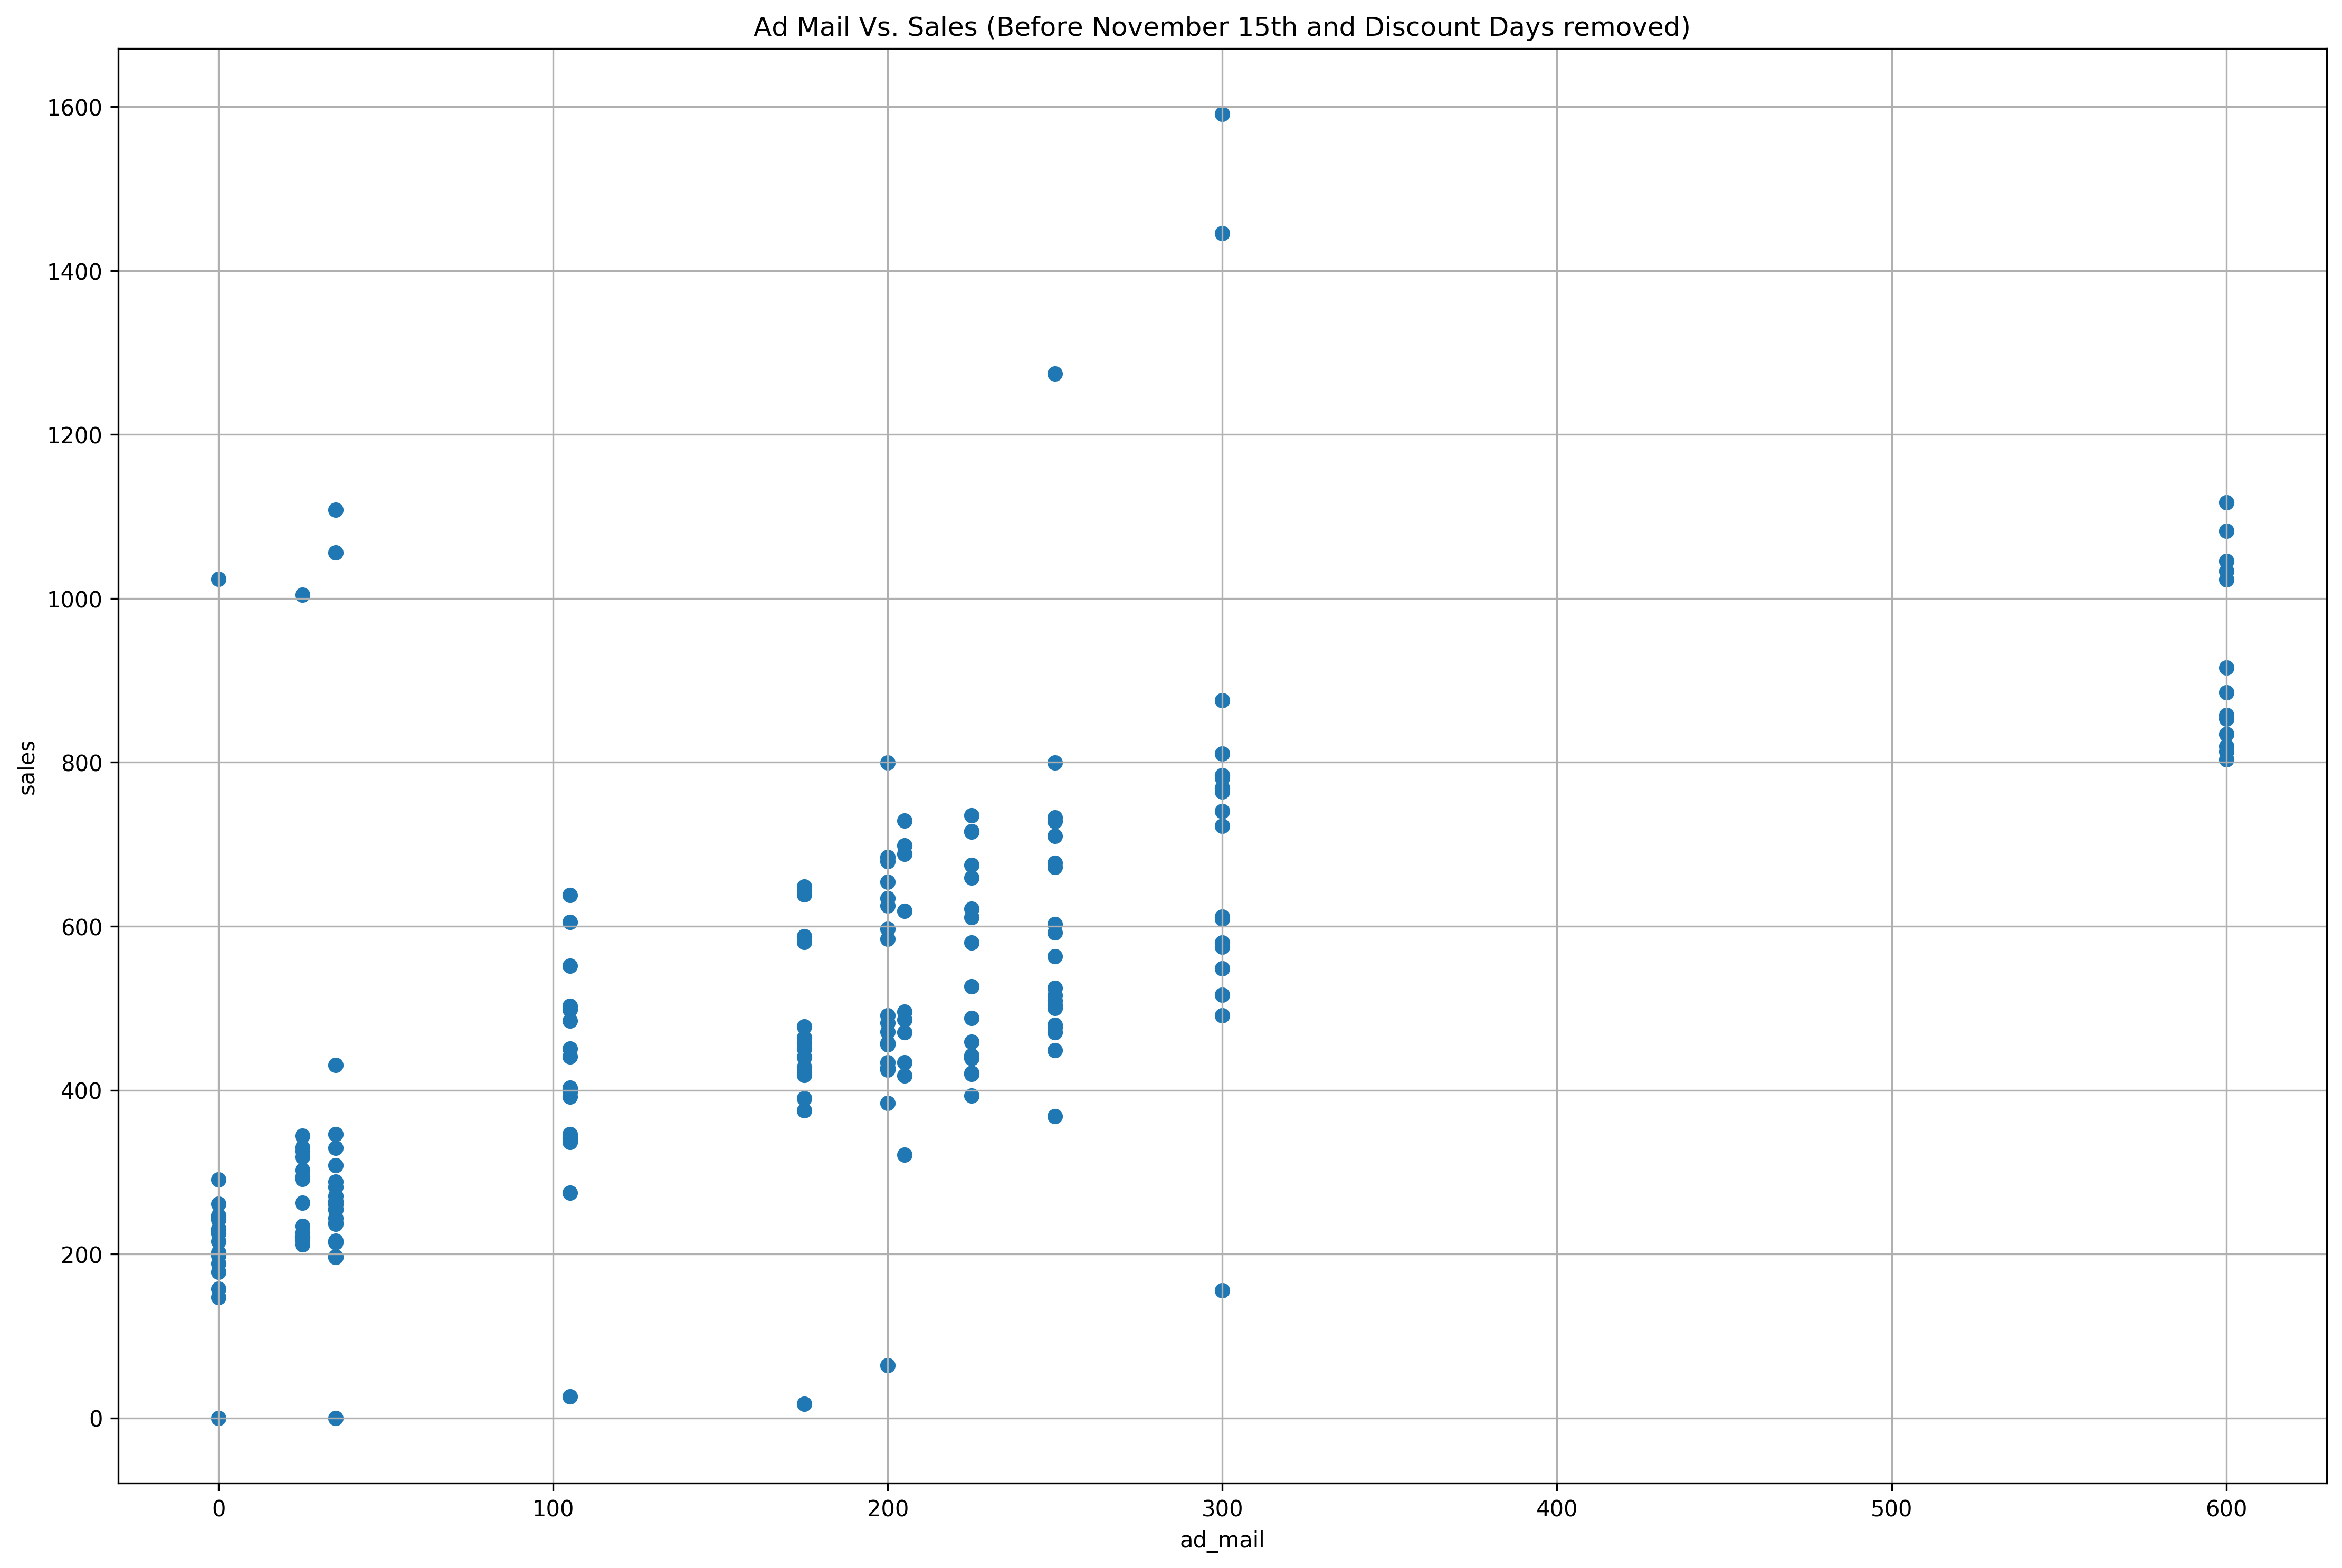

In [41]:
fig, ax = plt.subplots(1, 1)
ax.scatter(
    ads_sales_data_mailing_removed_discount_days_removed_date_after_nov_15['ad_mail'],
    ads_sales_data_mailing_removed_discount_days_removed_date_after_nov_15['sales']
)
ax.set_xlabel('ad_mail')
ax.set_ylabel('sales')
ax.grid()
ax.set_title('Ad Mail Vs. Sales (Before November 15th and Discount Days removed)')
plt.show();

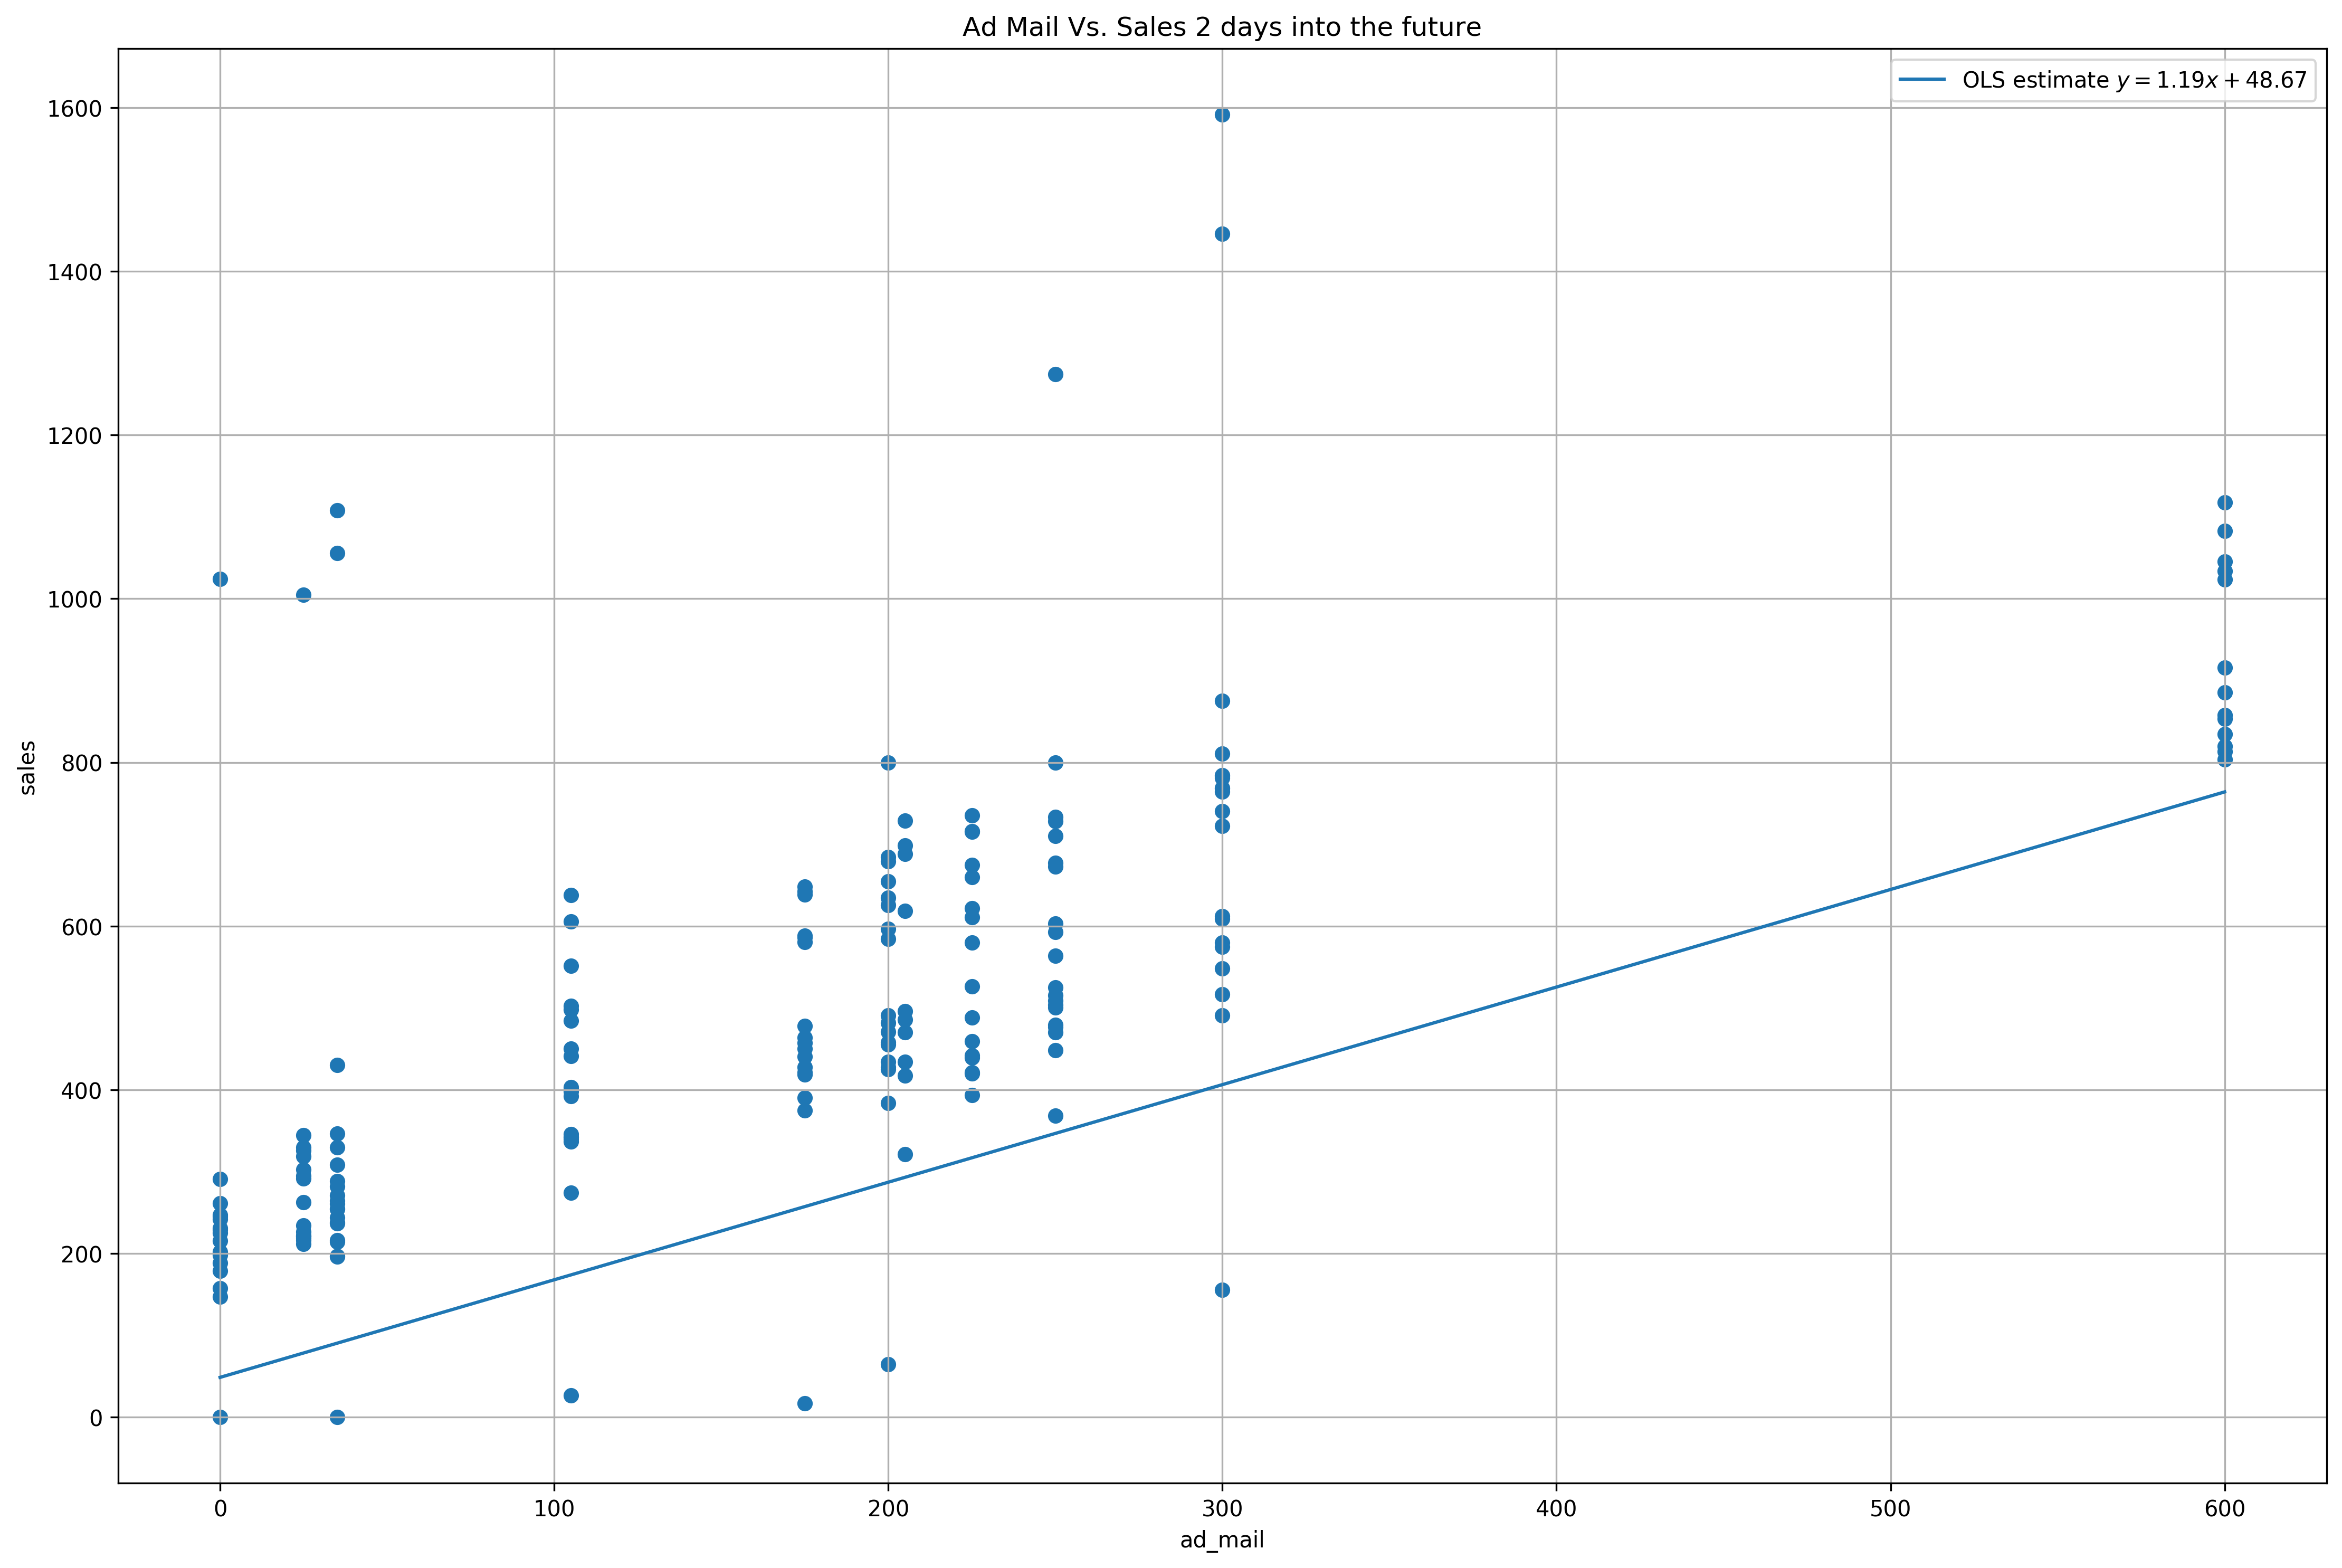

In [42]:
r = ads_sales_data_mailing_removed_discount_days_removed_date_after_nov_15.corr().iloc[0, 1]
s_y = ads_sales_data_mailing_removed_discount_days_removed_date_after_nov_15['sales'].std()
s_x = ads_sales_data_mailing_removed_discount_days_removed_date_after_nov_15['ad_mail'].std()
y_bar = ads_sales_data_mailing_removed_discount_days_removed_date_after_nov_15['sales'].std()
x_bar = ads_sales_data_mailing_removed_discount_days_removed_date_after_nov_15['ad_mail'].mean()
gradient = r * s_y / s_x
y_intercept = y_bar - (gradient * x_bar)
x = np.linspace(
    ads_sales_data_mailing_removed_discount_days_removed_date_after_nov_15['ad_mail'].min(),
    ads_sales_data_mailing_removed_discount_days_removed_date_after_nov_15['ad_mail'].max(),
    num=100
)
y_hat = np.add(np.dot(gradient, x), y_intercept)

fig, ax = plt.subplots(1, 1)
ax.plot(x, y_hat, label='OLS estimate $y = {}x + {}$'.format(round(gradient, 2), round(y_intercept, 2)))
ax.scatter(
    ads_sales_data_mailing_removed_discount_days_removed_date_after_nov_15['ad_mail'],
    ads_sales_data_mailing_removed_discount_days_removed_date_after_nov_15['sales']
)
ax.set_xlabel('ad_mail')
ax.set_ylabel('sales')
ax.grid()
ax.set_title('Ad Mail Vs. Sales 2 days into the future')
ax.legend()
plt.show();

### Filter out the Weekends too

We will remove the weekends too

---
## Ad Sales Online

In [51]:
ad_online_sales_decomposed = tsa.seasonal_decompose(ads_sales_data_online[['ad_online', 'sales']]);

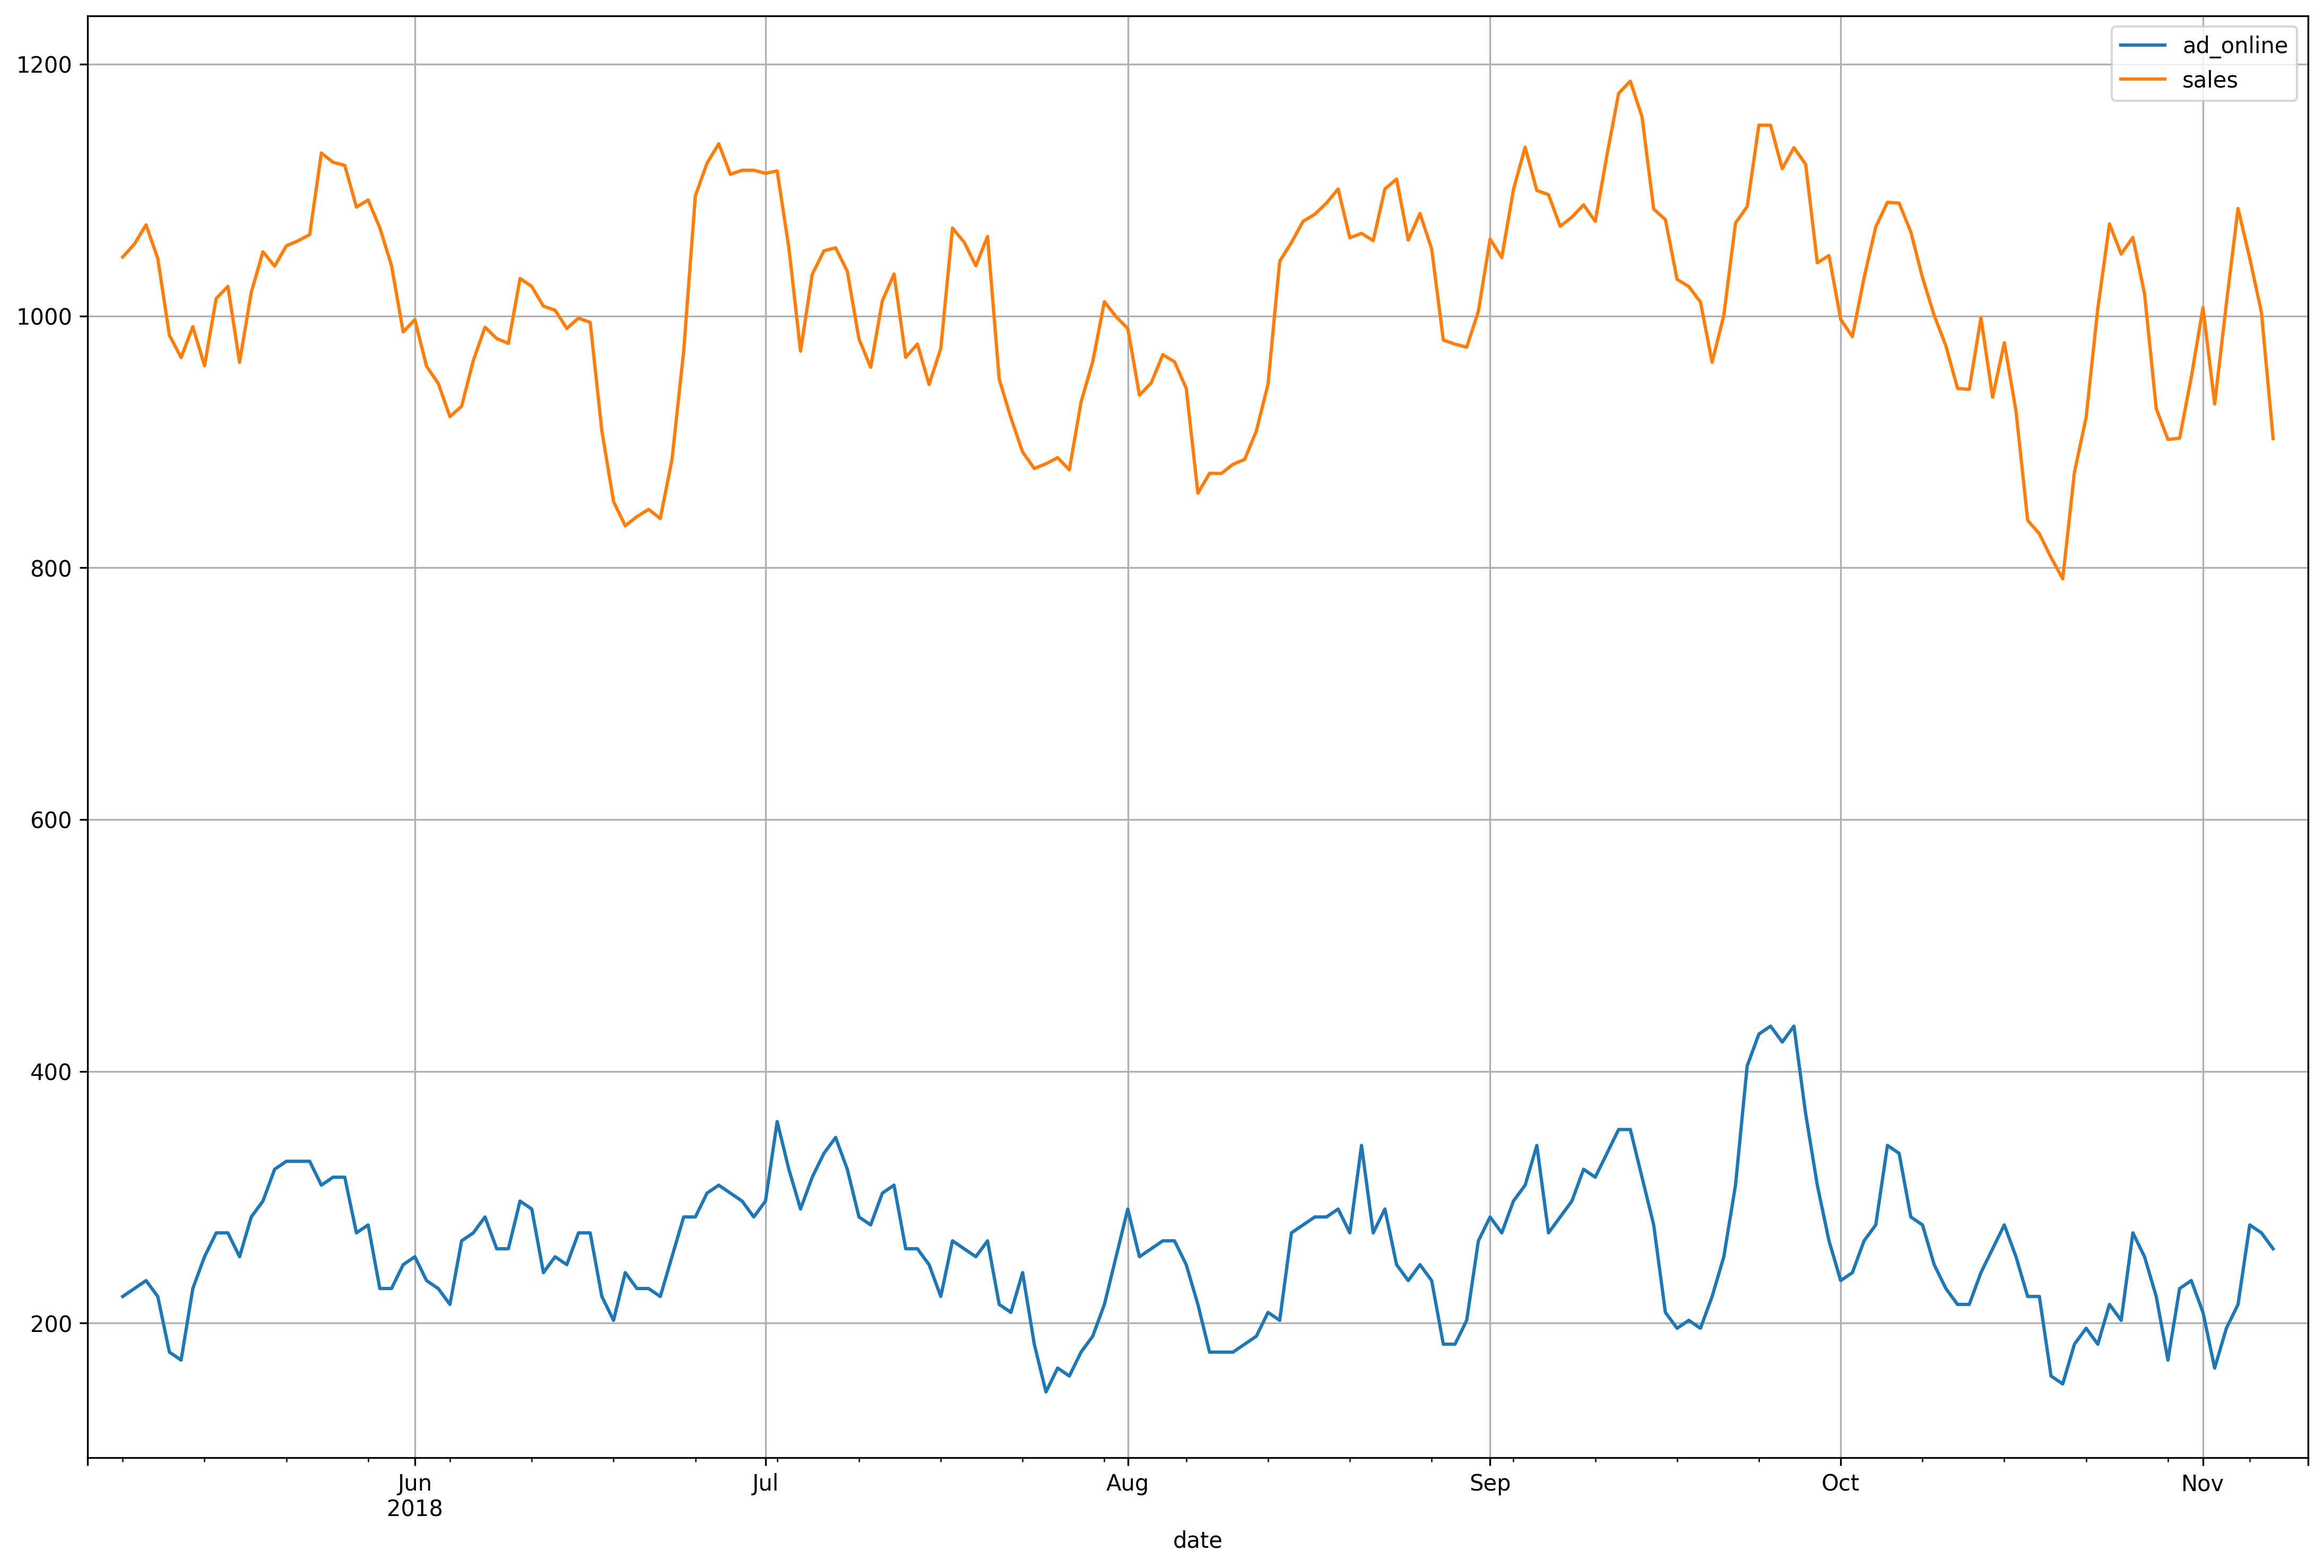

In [52]:
ad_online_sales_decomposed.trend.plot().grid();

---
# 4 Ps (Marketing Mix)

### Price

### Product
- *Product Line*: Breadth of product line is how many products that are  being offered

### Promotion

### Place

---
# 5 Cs

1. Company
2. Customers
3. Competitors
4. Collaborators
5. Climate

---
# Communication Channels

## One-Way
- Radio, Newspapers, Magazines, Television

## Two-Way
- 

---
# Push Strategy Vs. Pull Strategy

- When we already have the product we advertize and try to convince consumer to buy
- When we don't have product we ask consumer what they want

Willingness to Pay <-> Perceived Value

True Economic Value -> WTP when there is no uncertainty

True Economic Value - WTP = Risk Premium

Price Sensitivity
- Buyer Stickiness is the state dependence